DeepRitz ML model for solving the monodomain problem 
Using the IMEX time dependend formula 

In [17]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.nn.functional as F


In [18]:
# n_x, n_y grid size for x and y
# sigma_h, sigma_d conductivity of healthy and diseased regions
# dr, lists of the diseased regions points (x_center, y_center, radius) to fit the (x−0.3)^2 +(y−0.7)^2 <0.1^2 formulas
# returns a 2D array of all the points in the grid with the healthy and diseased regions marked
def cond_map(n_x, n_y, sigma_h, sigma_d, dr):
    x = np.linspace(0, 1, n_x)
    y = np.linspace(0, 1, n_y)
    X, Y = np.meshgrid(x, y, indexing='ij')
    sigma = np.full((n_x, n_y), sigma_h)

    for (xc, yc, r) in dr:
        mask = (X - xc)**2 + (Y - yc)**2 < r**2
        sigma[mask] = sigma_d

    return sigma


Initial condition function

Using device: cpu


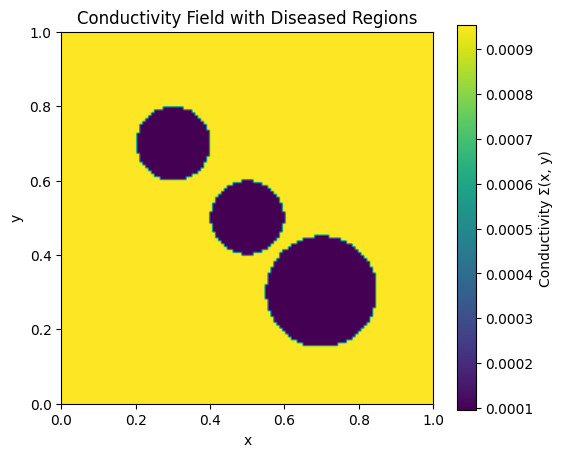

In [19]:
# params
n_x, n_y = 128, 128
dr = [(0.3, 0.7, 0.1), (0.7, 0.3, 0.15), (0.5, 0.5, 0.1)]
sigma_h = 9.5298e-4
# sigma_d = 10 * sigma_h
# sigma_d = sigma_h
sigma_d = 0.1 * sigma_h
a = 18.515
ft = 0.2383
fr = 0
fd = 1
T = 35
sigma = cond_map(n_x, n_y, sigma_h, sigma_d, dr)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
sigma_t = torch.tensor(sigma.flatten(), dtype=torch.float32).to(device)


# heart map values
plt.figure(figsize=(6, 5))
plt.imshow(sigma.T, origin='lower', extent=[0,1,0,1], cmap='viridis')
plt.colorbar(label='Conductivity Σ(x, y)')
plt.title('Conductivity Field with Diseased Regions')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(False)
plt.show()



In [20]:
# u0(x, y) = 1 if x ≥ 0.9 and y ≥ 0.9, else 0.
# returns u0 as a 2D array
def ic(n_x, n_y):
    x = np.linspace(0, 1, n_x)
    y = np.linspace(0, 1, n_y)
    X, Y = np.meshgrid(x, y, indexing='ij')

    u0 = np.zeros((n_x, n_y))
    u0[(X >= 0.9) & (Y >= 0.9)] = 1.0
    return u0

Reaction term

In [21]:
# reaction term 
def R(u, a, fr, ft, fd):
    return a * (u - fr) * (u - ft) * (u - fd)

RHS of the IMEX eq

In [22]:
# RHS = (1/dt) * u^n + f(u^n)
# u_n, solution at time step n
# dt : time step size
# returns a 2D array pf the rhs
def rhs(u_n, a, fr, ft, fd, dt):
    f_un = R(u_n, a, fr, ft, fd)
    return (1.0 / dt) * u_n + f_un

Model 

In [23]:
class DeepRitz(nn.Module):
    def __init__(self, input_dim=2, output_dim=1, w=64, d=4):
        super().__init__()
        self.linear = nn.ModuleList([nn.Linear(w if i>0 else input_dim, w) for i in range(d)])
        self.linearOut = nn.Linear(w, output_dim)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)  
                nn.init.zeros_(m.bias)

    # def forward(self, x):
    #     x = F.softplus(self.linear[0](x))  
    #     for layer in self.linear[1:]:
    #         x_temp = F.softplus(layer(x))
    #         x = x + x_temp
    #     return self.linearOut(x)
    
    def forward(self, x):
        x = F.softplus(self.linear[0](x))
        for layer in self.linear[1:]:
            x_temp = F.softplus(layer(x))
            x = x + x_temp
        return torch.sigmoid(self.linearOut(x))


Sample points

In [24]:
# sample collocation points, random uniform 
# biased to add more to the ic 

def sampling_pools(n_x, n_y, disease_mask):
    x = np.linspace(0, 1, n_x)
    y = np.linspace(0, 1, n_y)
    X, Y = np.meshgrid(x, y, indexing='ij')
    coords = np.stack([X.flatten(), Y.flatten()], axis=-1)

    disease_pts = coords[disease_mask.flatten() == 1]
    ic_mask = (coords[:, 0] > 0.9) & (coords[:, 1] > 0.9)
    ic_pts = coords[ic_mask]
    full_pts = coords

    return full_pts, disease_pts, ic_pts

def sample_from_pools(full_pts, disease_pts, ic_pts, N, br_ic=0.2, br_disease=0.3):
    n_ic = int(N * br_ic)
    n_disease = int(N * br_disease)
    n_uniform = N - n_ic - n_disease

    idx_full = np.random.choice(len(full_pts), n_uniform, replace=(n_uniform > len(full_pts)))
    idx_disease = np.random.choice(len(disease_pts), n_disease, replace=(n_disease > len(disease_pts)))
    idx_ic = np.random.choice(len(ic_pts), n_ic, replace=(n_ic > len(ic_pts)))

    selected = np.concatenate([
        full_pts[idx_full],
        disease_pts[idx_disease],
        ic_pts[idx_ic]
    ])

    return torch.tensor(selected, dtype=torch.float32)

Energy function

In [25]:
# interpolation functions to allow samplinh at the collocation points
def rhs_norm(points):
    idx_x = (points[:, 0] * (n_x - 1)).long()
    idx_y = (points[:, 1] * (n_y - 1)).long()
    return rhs_t[idx_x * n_y + idx_y].unsqueeze(1)

def sigma_norm(points):
    idx_x = (points[:, 0] * (n_x - 1)).long()
    idx_y = (points[:, 1] * (n_y - 1)).long()
    return sigma_t[idx_x * n_y + idx_y].unsqueeze(1)

def energy_f(model, points, sigma_norm, rhs_norm, dt , u_n):
    points.requires_grad_(True)
    u = model(points).squeeze()
    grad_u = autograd.grad(outputs=u, inputs=points, grad_outputs=torch.ones_like(u), create_graph=True)[0] # ∇u^{n+1}
    sigma_vals = sigma_norm(points).squeeze()        # sigma(x, y)
    rhs_vals = rhs_norm(points).squeeze()            # (1/dt) u^n - f(u^n)
    idx_x = (points[:, 0] * (n_x - 1)).long()
    idx_y = (points[:, 1] * (n_y - 1)).long()
    u_n_interp = u_n[idx_x * n_y + idx_y]

    grad_norm_sq = (grad_u**2).sum(dim=1)            # ||grad(u)||²

    # M u^(n+1) + dt K u^{n+1} = M u^n - dt f(u^n)
    # where K = 1/2 *sigma * grad^2
    energy = ((0.5 / dt) * (u - u_n_interp)**2 + 0.5 * sigma_vals * grad_norm_sq - rhs_vals * u).mean()
    return energy.mean() 

Training 

In [26]:
# training func
def train(model, points, sigma_norm, rhs_norm, dt, lr, steps, device, =None, full_grid=None, u_n=None):
    model.train()
    points = points.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []

    for epoch in range(steps):
        optimizer.zero_grad()
        loss = energy_f(model, points, sigma_norm, rhs_norm, dt, u_n)
        if ic_target is not None and full_grid is not None:   # to weight gradient loss for reinforcement of it
            model.eval()
            u_pred = model(full_grid).squeeze()
            ic_loss = F.mse_loss(u_pred, ic_target)
            loss += 100* ic_loss  
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        losses.append(loss.item())

        if (epoch + 1) % (steps // 10 if steps >= 10 else 1) == 0:
            print(f"    Epoch [{epoch+1}/{steps}], Loss: {loss.item():.8f}")
    
    return model, losses

In [27]:
def stats(model, xy, u_n, sigma_norm, dt, a, fr, ft, fd):
    xy = xy.clone().detach().requires_grad_(True)
    u_pred = model(xy).squeeze()
    grad_u = autograd.grad(u_pred, xy, grad_outputs=torch.ones_like(u_pred),create_graph=True, retain_graph=True)[0]
    sigma_vals = sigma_norm(xy).squeeze()
    flux = sigma_vals.unsqueeze(-1) * grad_u
    div_diff = 0
    for i in range(xy.shape[1]):
        div_flux_i = autograd.grad(
            outputs=flux[:, i],
            inputs=xy,
            grad_outputs=torch.ones_like(flux[:, i]),
            create_graph=True,
            retain_graph=True
        )[0][:, i]
        div_diff += div_flux_i

    idx_x = (xy[:, 0] * (n_x - 1)).long()
    idx_y = (xy[:, 1] * (n_y - 1)).long()
    u_n_vals = u_n[idx_x * n_y + idx_y].to(xy.device)
    f_un = R(u_n_vals, a, fr, ft, fd)
    dt_u_term = (u_pred - u_n_vals) / dt
    residual = dt_u_term - div_diff + f_un

    return {
        'du_dt': dt_u_term.detach().cpu().numpy(),
        'diffusion': (-div_diff).detach().cpu().numpy(),
        'reaction': f_un.detach().cpu().numpy(),
        'residual': residual.detach().cpu().numpy(),
        'grad_u': grad_u.detach().cpu().numpy()
    }

In [28]:
# compute the graddient 
def grad(model, x):
    x.requires_grad_(True) 
    u = model(x) 
    if u.ndim == 2 and u.shape[1] == 1:
        u = u.squeeze(-1)
    grad_u = torch.autograd.grad(outputs=u,inputs=x,grad_outputs=torch.ones_like(u),create_graph=True,retain_graph=True,only_inputs=True)[0]
    return grad_u

In [29]:
# //// param def ////////////////////
dt = 0.5
N = int(T/dt)
steps = 800
colloc_p = 1024
w = 64 
d = 4
lr = 1e-4  # could get smaller 

deepRM = DeepRitz(input_dim=2, output_dim=1, w=w, d=d).to(device)

# Make binary disease mask from sigma
disease_mask = (sigma < sigma_h).astype(np.uint8)
full_pts, disease_pts, ic_pts = sampling_pools(n_x, n_y, disease_mask)

x = np.linspace(0, 1, n_x)
y = np.linspace(0, 1, n_y)
X, Y = np.meshgrid(x, y, indexing='ij')
xy_coords = np.stack([X.flatten(), Y.flatten()], axis=-1)
xy_t = torch.tensor(xy_coords, dtype=torch.float32).to(device)

u_n = ic(n_x, n_y)
u_n = torch.tensor(u_n.flatten(), dtype=torch.float32)
u_np = u_n.detach().numpy().reshape(n_x, n_y)

rhs_v = rhs(u_np, a, fr, ft, fd, dt).flatten()
rhs_t = torch.tensor(rhs_v, dtype=torch.float32).to(device)

iter: 0 ###############################
    Epoch [80/800], Loss: 1.03349173
    Epoch [160/800], Loss: 1.03099418
    Epoch [240/800], Loss: 1.02756345
    Epoch [320/800], Loss: 1.02113962
    Epoch [400/800], Loss: 1.00337732
    Epoch [480/800], Loss: 0.90662384
    Epoch [560/800], Loss: 0.66527265
    Epoch [640/800], Loss: 0.59406644
    Epoch [720/800], Loss: 0.53503239
    Epoch [800/800], Loss: 0.48992097
    Energy after iteration 0: -0.005245


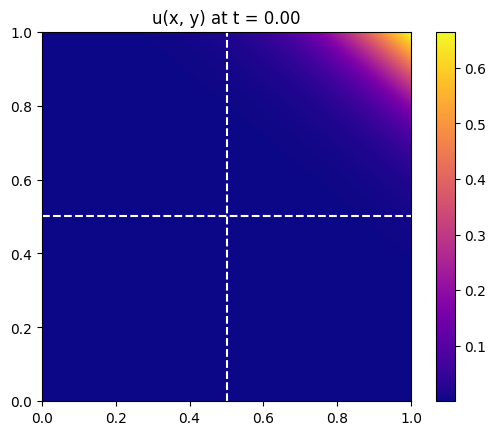

RHS max: 5.1936e-01, min: -4.3423e-01, mean: 3.7623e-02


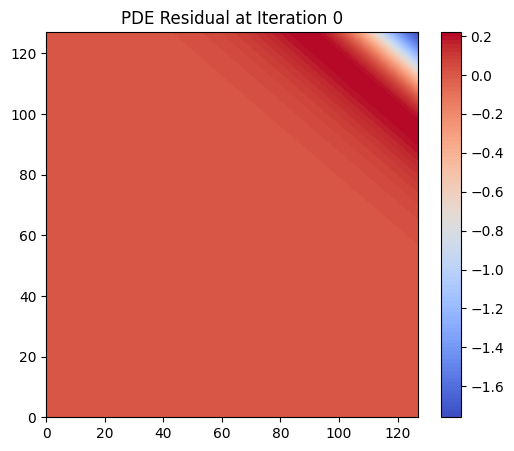

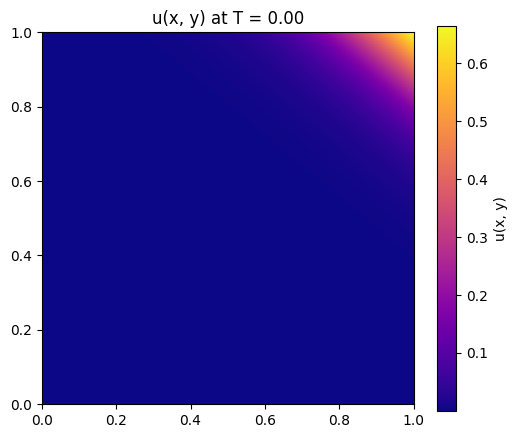

iter: 1 ###############################
    Epoch [80/800], Loss: 0.00632980
    Epoch [160/800], Loss: 0.00595862
    Epoch [240/800], Loss: 0.00500391
    Epoch [320/800], Loss: 0.00446479
    Epoch [400/800], Loss: 0.00403234
    Epoch [480/800], Loss: 0.00367052
    Epoch [560/800], Loss: 0.00334783
    Epoch [640/800], Loss: 0.00316837
    Epoch [720/800], Loss: 0.00311910
    Epoch [800/800], Loss: 0.00310725
    Energy after iteration 1: 0.040572


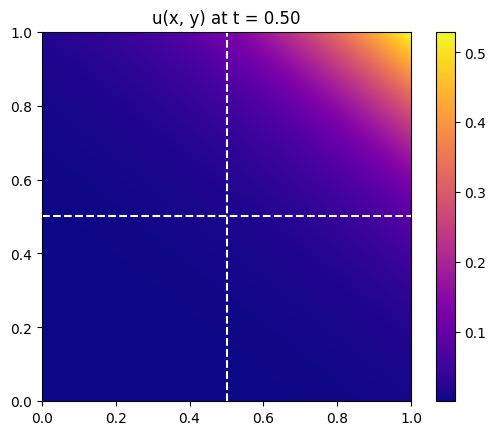

RHS max: 5.1936e-01, min: -2.8450e-01, mean: 1.4335e-01
iter: 2 ###############################
    Epoch [80/800], Loss: -0.00416886
    Epoch [160/800], Loss: -0.00581293
    Epoch [240/800], Loss: -0.00632344
    Epoch [320/800], Loss: -0.00633970
    Epoch [400/800], Loss: -0.00634604
    Epoch [480/800], Loss: -0.00635363
    Epoch [560/800], Loss: -0.00636275
    Epoch [640/800], Loss: -0.00637353
    Epoch [720/800], Loss: -0.00638563
    Epoch [800/800], Loss: -0.00639835
    Energy after iteration 2: 0.036927


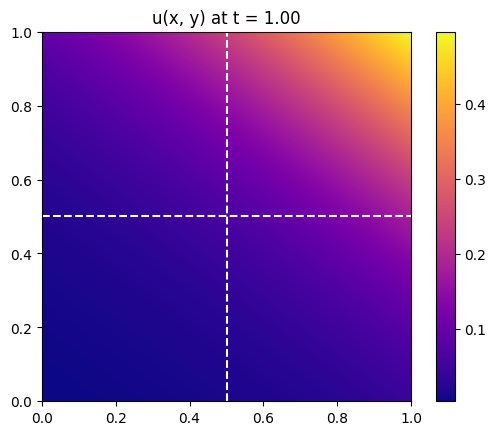

RHS max: 5.1936e-01, min: -2.0099e-01, mean: 2.9502e-01
iter: 3 ###############################
    Epoch [80/800], Loss: -0.03938619
    Epoch [160/800], Loss: -0.04132643
    Epoch [240/800], Loss: -0.04140725
    Epoch [320/800], Loss: -0.04144290
    Epoch [400/800], Loss: -0.04147675
    Epoch [480/800], Loss: -0.04151130
    Epoch [560/800], Loss: -0.04154943
    Epoch [640/800], Loss: -0.04159196
    Epoch [720/800], Loss: -0.04163539
    Epoch [800/800], Loss: -0.04167689
    Energy after iteration 3: 0.025933


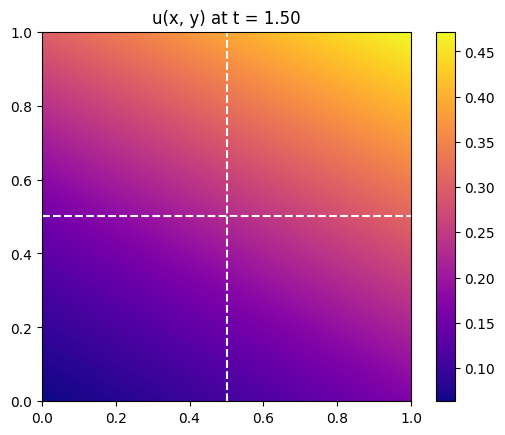

RHS max: 5.1936e-01, min: -1.3370e-01, mean: 3.9723e-01
iter: 4 ###############################
    Epoch [80/800], Loss: -0.11204733
    Epoch [160/800], Loss: -0.11374867
    Epoch [240/800], Loss: -0.11389971
    Epoch [320/800], Loss: -0.11398413
    Epoch [400/800], Loss: -0.11409153
    Epoch [480/800], Loss: -0.11420365
    Epoch [560/800], Loss: -0.11430353
    Epoch [640/800], Loss: -0.11439772
    Epoch [720/800], Loss: -0.11449552
    Epoch [800/800], Loss: -0.11460097
    Energy after iteration 4: 0.048461


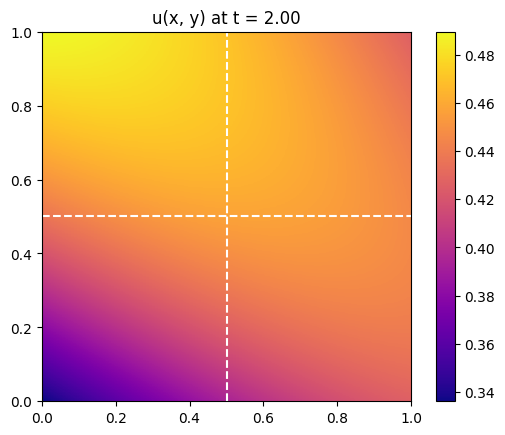

RHS max: 2.6813e-01, min: -1.8334e-01, mean: -4.9760e-02
iter: 5 ###############################
    Epoch [80/800], Loss: 0.03028270
    Epoch [160/800], Loss: 0.03009563
    Epoch [240/800], Loss: 0.02997332
    Epoch [320/800], Loss: 0.02989708
    Epoch [400/800], Loss: 0.02984495
    Epoch [480/800], Loss: 0.02980450
    Epoch [560/800], Loss: 0.02976869
    Epoch [640/800], Loss: 0.02973373
    Epoch [720/800], Loss: 0.02970045
    Epoch [800/800], Loss: 0.02967254
    Energy after iteration 5: 0.201072


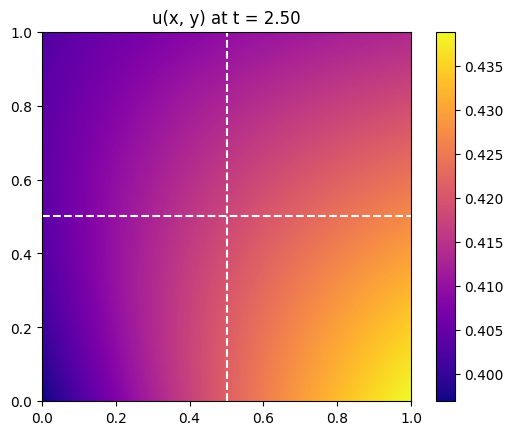

RHS max: 9.0763e-02, min: -3.6821e-02, mean: 3.1918e-02
iter: 6 ###############################
    Epoch [80/800], Loss: -0.01427606
    Epoch [160/800], Loss: -0.01430437
    Epoch [240/800], Loss: -0.01431983
    Epoch [320/800], Loss: -0.01432637
    Epoch [400/800], Loss: -0.01432905
    Epoch [480/800], Loss: -0.01433050
    Epoch [560/800], Loss: -0.01433161
    Epoch [640/800], Loss: -0.01433259
    Epoch [720/800], Loss: -0.01433349
    Epoch [800/800], Loss: -0.01433433
    Energy after iteration 6: 0.172413


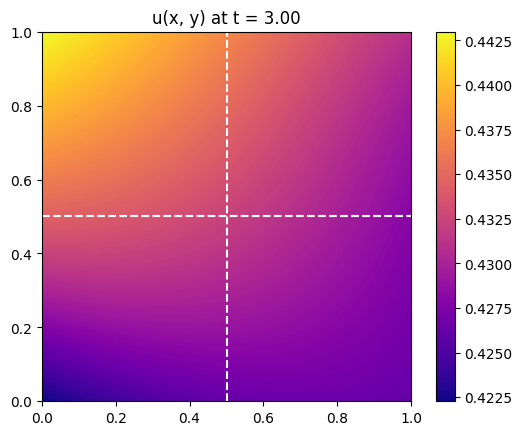

RHS max: 1.3550e-02, min: -4.9149e-02, mean: -1.5100e-02
iter: 7 ###############################
    Epoch [80/800], Loss: 0.00744877
    Epoch [160/800], Loss: 0.00744186
    Epoch [240/800], Loss: 0.00743798
    Epoch [320/800], Loss: 0.00743637
    Epoch [400/800], Loss: 0.00743578
    Epoch [480/800], Loss: 0.00743551
    Epoch [560/800], Loss: 0.00743532
    Epoch [640/800], Loss: 0.00743514
    Epoch [720/800], Loss: 0.00743498
    Epoch [800/800], Loss: 0.00743482
    Energy after iteration 7: 0.186926


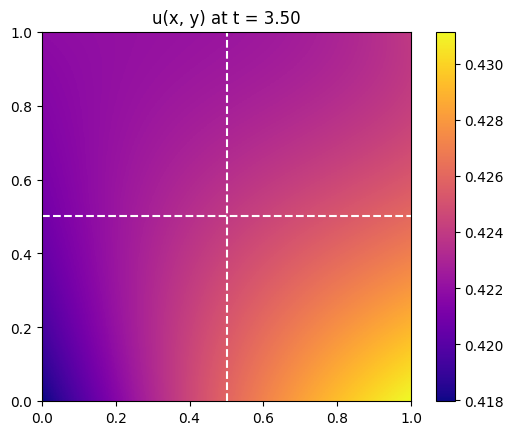

RHS max: 2.6678e-02, min: -1.3467e-02, mean: 8.7330e-03
iter: 8 ###############################
    Epoch [80/800], Loss: -0.00386711
    Epoch [160/800], Loss: -0.00386955
    Epoch [240/800], Loss: -0.00387057
    Epoch [320/800], Loss: -0.00387100
    Epoch [400/800], Loss: -0.00387118
    Epoch [480/800], Loss: -0.00387127
    Epoch [560/800], Loss: -0.00387135
    Epoch [640/800], Loss: -0.00387142
    Epoch [720/800], Loss: -0.00387149
    Epoch [800/800], Loss: -0.00387155
    Energy after iteration 8: 0.179533


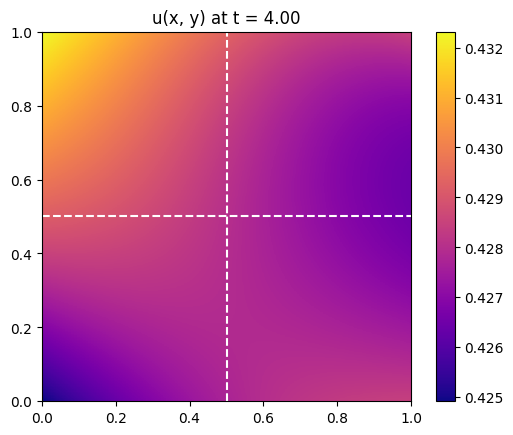

RHS max: 5.5076e-03, min: -1.6973e-02, mean: -4.2886e-03
iter: 9 ###############################
    Epoch [80/800], Loss: 0.00210768
    Epoch [160/800], Loss: 0.00210692
    Epoch [240/800], Loss: 0.00210664
    Epoch [320/800], Loss: 0.00210652
    Epoch [400/800], Loss: 0.00210649
    Epoch [480/800], Loss: 0.00210647
    Epoch [560/800], Loss: 0.00210647
    Epoch [640/800], Loss: 0.00210646
    Epoch [720/800], Loss: 0.00210646
    Epoch [800/800], Loss: 0.00210645
    Energy after iteration 9: 0.183478


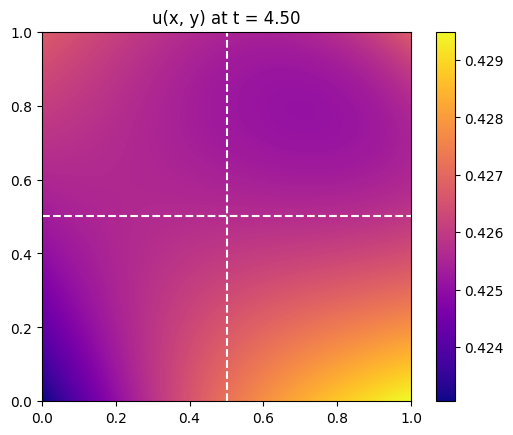

RHS max: 1.1178e-02, min: -8.3993e-03, mean: 2.4965e-03
iter: 10 ###############################
    Epoch [80/800], Loss: -0.00106473
    Epoch [160/800], Loss: -0.00106488
    Epoch [240/800], Loss: -0.00106496
    Epoch [320/800], Loss: -0.00106500
    Epoch [400/800], Loss: -0.00106501
    Epoch [480/800], Loss: -0.00106501
    Epoch [560/800], Loss: -0.00106501
    Epoch [640/800], Loss: -0.00106501
    Epoch [720/800], Loss: -0.00106501
    Epoch [800/800], Loss: -0.00106501
    Energy after iteration 10: 0.181395


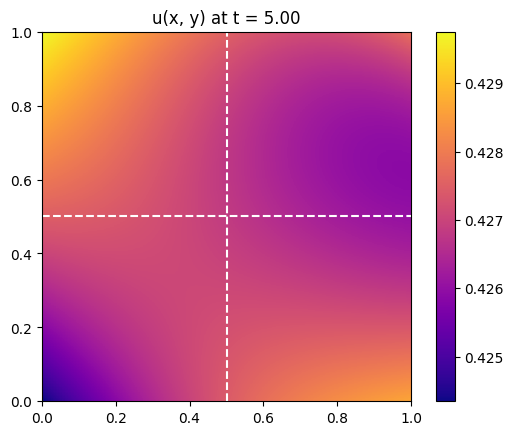

RHS max: 7.2374e-03, min: -9.1857e-03, mean: -9.6987e-04


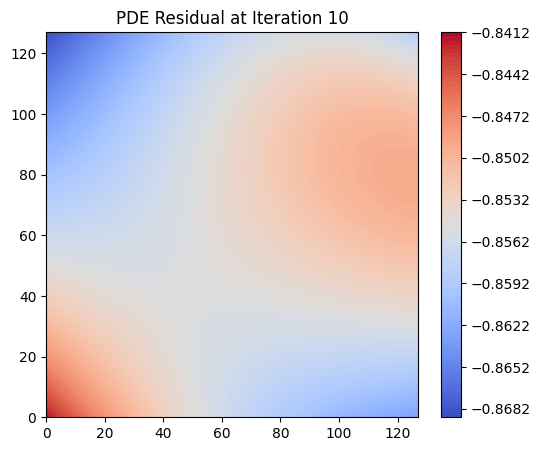

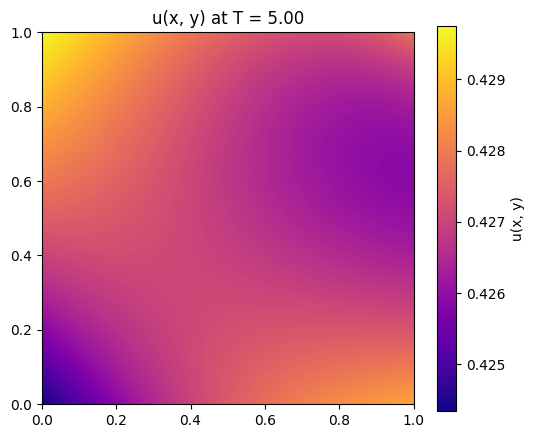

iter: 11 ###############################
    Epoch [80/800], Loss: 0.00053202
    Epoch [160/800], Loss: 0.00053196
    Epoch [240/800], Loss: 0.00053194
    Epoch [320/800], Loss: 0.00053192
    Epoch [400/800], Loss: 0.00053192
    Epoch [480/800], Loss: 0.00053192
    Epoch [560/800], Loss: 0.00053192
    Epoch [640/800], Loss: 0.00053191
    Epoch [720/800], Loss: 0.00053191
    Epoch [800/800], Loss: 0.00053191
    Energy after iteration 11: 0.182446


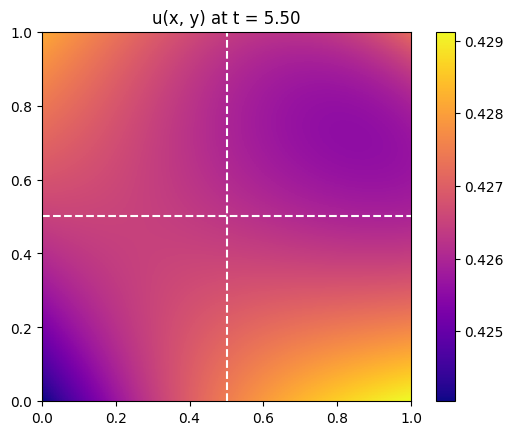

RHS max: 8.1931e-03, min: -7.2811e-03, mean: 6.9013e-04
iter: 12 ###############################
    Epoch [80/800], Loss: -0.00026746
    Epoch [160/800], Loss: -0.00026753
    Epoch [240/800], Loss: -0.00026754
    Epoch [320/800], Loss: -0.00026754
    Epoch [400/800], Loss: -0.00026754
    Epoch [480/800], Loss: -0.00026754
    Epoch [560/800], Loss: -0.00026754
    Epoch [640/800], Loss: -0.00026754
    Epoch [720/800], Loss: -0.00026754
    Epoch [800/800], Loss: -0.00026755
    Energy after iteration 12: 0.181921


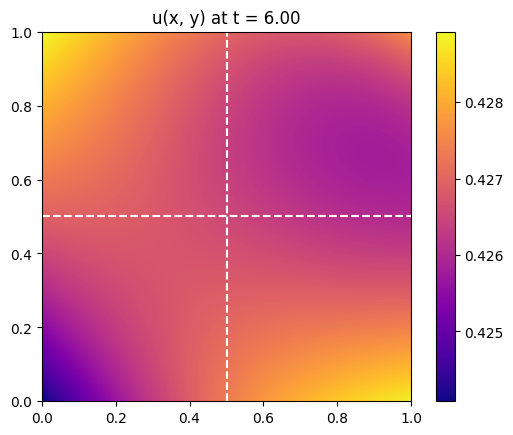

RHS max: 8.0403e-03, min: -6.6670e-03, mean: -7.5366e-05
iter: 13 ###############################
    Epoch [80/800], Loss: 0.00017541
    Epoch [160/800], Loss: 0.00017532
    Epoch [240/800], Loss: 0.00017532
    Epoch [320/800], Loss: 0.00017531
    Epoch [400/800], Loss: 0.00017531
    Epoch [480/800], Loss: 0.00017531
    Epoch [560/800], Loss: 0.00017531
    Epoch [640/800], Loss: 0.00017531
    Epoch [720/800], Loss: 0.00017531
    Epoch [800/800], Loss: 0.00017531
    Energy after iteration 13: 0.182212


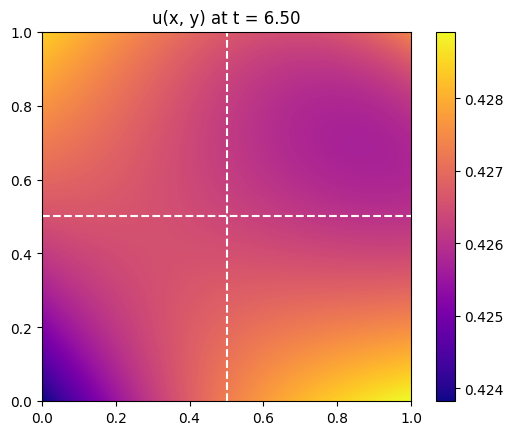

RHS max: 8.8406e-03, min: -6.6640e-03, mean: 4.8908e-04
iter: 14 ###############################
    Epoch [80/800], Loss: -0.00013615
    Epoch [160/800], Loss: -0.00013628
    Epoch [240/800], Loss: -0.00013629
    Epoch [320/800], Loss: -0.00013629
    Epoch [400/800], Loss: -0.00013629
    Epoch [480/800], Loss: -0.00013629
    Epoch [560/800], Loss: -0.00013629
    Epoch [640/800], Loss: -0.00013629
    Epoch [720/800], Loss: -0.00013629
    Epoch [800/800], Loss: -0.00013629
    Energy after iteration 14: 0.182007


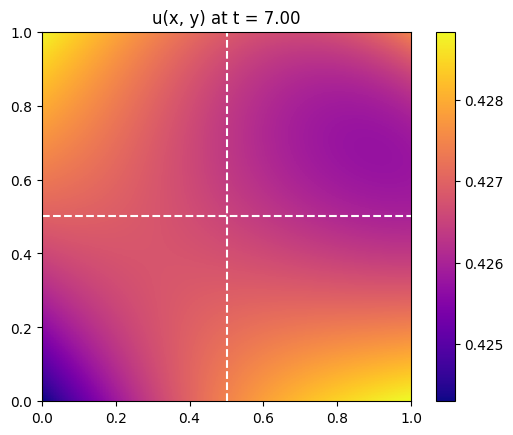

RHS max: 7.3894e-03, min: -6.4059e-03, mean: -4.2581e-05
iter: 15 ###############################
    Epoch [80/800], Loss: 0.00012047
    Epoch [160/800], Loss: 0.00012032
    Epoch [240/800], Loss: 0.00012032
    Epoch [320/800], Loss: 0.00012032
    Epoch [400/800], Loss: 0.00012032
    Epoch [480/800], Loss: 0.00012032
    Epoch [560/800], Loss: 0.00012032
    Epoch [640/800], Loss: 0.00012032
    Epoch [720/800], Loss: 0.00012032
    Epoch [800/800], Loss: 0.00012032
    Energy after iteration 15: 0.182176


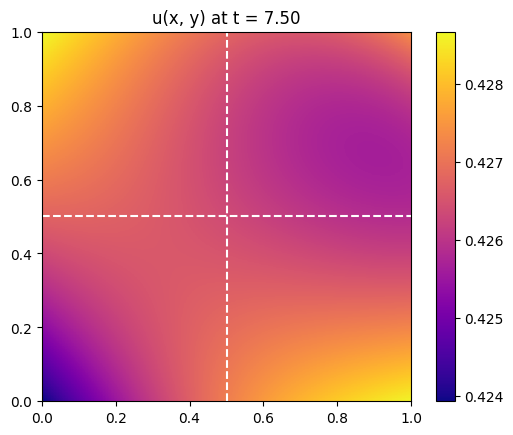

RHS max: 8.5010e-03, min: -5.9001e-03, mean: 4.6972e-04
iter: 16 ###############################
    Epoch [80/800], Loss: -0.00009079
    Epoch [160/800], Loss: -0.00009102
    Epoch [240/800], Loss: -0.00009102
    Epoch [320/800], Loss: -0.00009102
    Epoch [400/800], Loss: -0.00009102
    Epoch [480/800], Loss: -0.00009102
    Epoch [560/800], Loss: -0.00009103
    Epoch [640/800], Loss: -0.00009103
    Epoch [720/800], Loss: -0.00009103
    Epoch [800/800], Loss: -0.00009103
    Energy after iteration 16: 0.182037


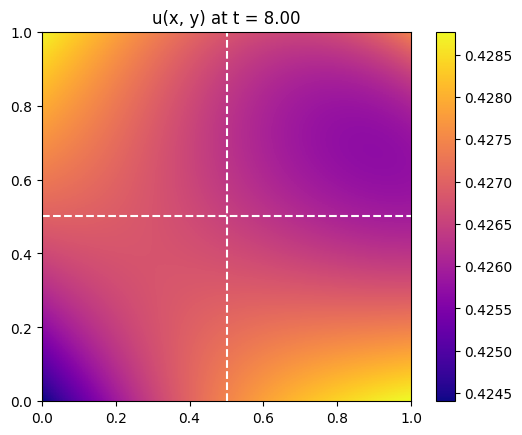

RHS max: 7.0732e-03, min: -6.2091e-03, mean: 3.4402e-05
iter: 17 ###############################
    Epoch [80/800], Loss: 0.00007484
    Epoch [160/800], Loss: 0.00007460
    Epoch [240/800], Loss: 0.00007460
    Epoch [320/800], Loss: 0.00007460
    Epoch [400/800], Loss: 0.00007460
    Epoch [480/800], Loss: 0.00007460
    Epoch [560/800], Loss: 0.00007460
    Epoch [640/800], Loss: 0.00007459
    Epoch [720/800], Loss: 0.00007459
    Epoch [800/800], Loss: 0.00007459
    Energy after iteration 17: 0.182146


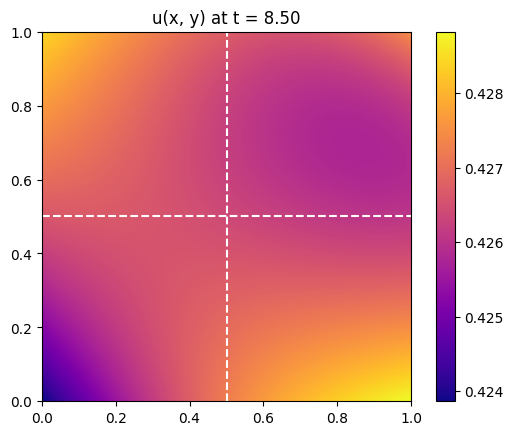

RHS max: 8.7070e-03, min: -6.3726e-03, mean: 4.1282e-04
iter: 18 ###############################
    Epoch [80/800], Loss: -0.00007986
    Epoch [160/800], Loss: -0.00008020
    Epoch [240/800], Loss: -0.00008020
    Epoch [320/800], Loss: -0.00008020
    Epoch [400/800], Loss: -0.00008020
    Epoch [480/800], Loss: -0.00008020
    Epoch [560/800], Loss: -0.00008020
    Epoch [640/800], Loss: -0.00008020
    Epoch [720/800], Loss: -0.00008020
    Epoch [800/800], Loss: -0.00008020
    Energy after iteration 18: 0.182044


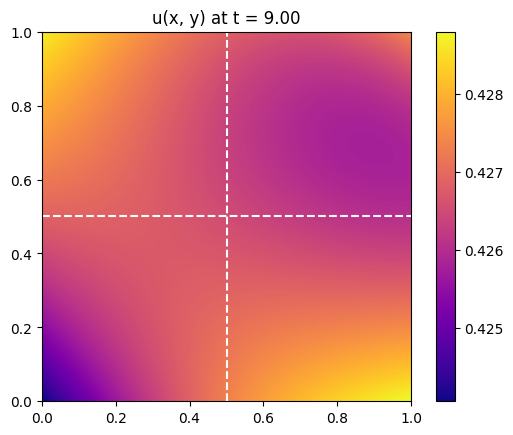

RHS max: 8.0954e-03, min: -6.2664e-03, mean: 7.2041e-05
iter: 19 ###############################
    Epoch [80/800], Loss: 0.00005234
    Epoch [160/800], Loss: 0.00005203
    Epoch [240/800], Loss: 0.00005203
    Epoch [320/800], Loss: 0.00005203
    Epoch [400/800], Loss: 0.00005203
    Epoch [480/800], Loss: 0.00005203
    Epoch [560/800], Loss: 0.00005203
    Epoch [640/800], Loss: 0.00005203
    Epoch [720/800], Loss: 0.00005203
    Epoch [800/800], Loss: 0.00005203
    Energy after iteration 19: 0.182131


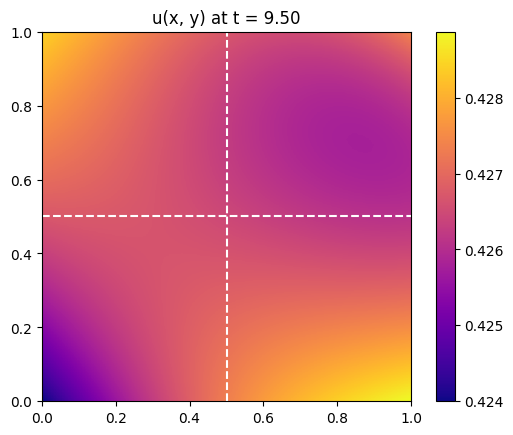

RHS max: 8.3259e-03, min: -6.5333e-03, mean: 2.5258e-04
iter: 20 ###############################
    Epoch [80/800], Loss: -0.00005470
    Epoch [160/800], Loss: -0.00005516
    Epoch [240/800], Loss: -0.00005516
    Epoch [320/800], Loss: -0.00005516
    Epoch [400/800], Loss: -0.00005516
    Epoch [480/800], Loss: -0.00005516
    Epoch [560/800], Loss: -0.00005516
    Epoch [640/800], Loss: -0.00005516
    Epoch [720/800], Loss: -0.00005516
    Epoch [800/800], Loss: -0.00005516
    Energy after iteration 20: 0.182061


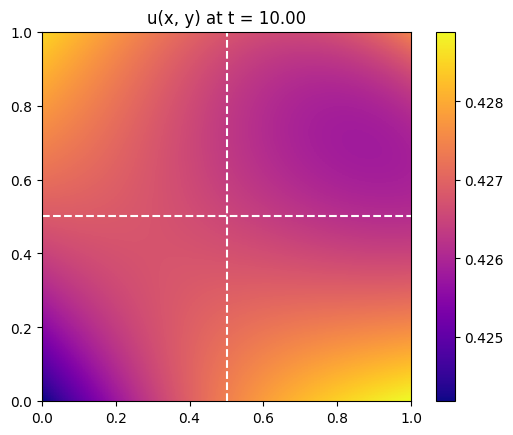

RHS max: 7.7595e-03, min: -6.5703e-03, mean: 3.6588e-05


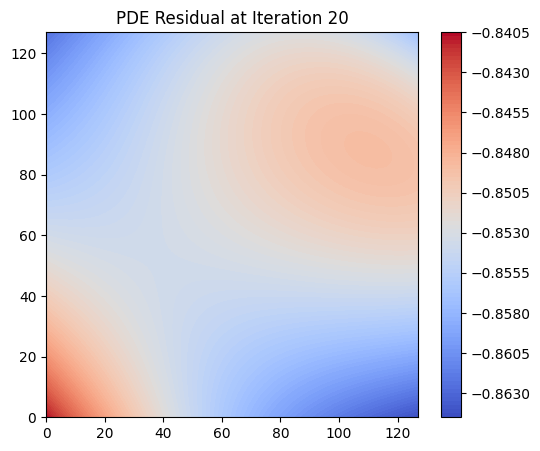

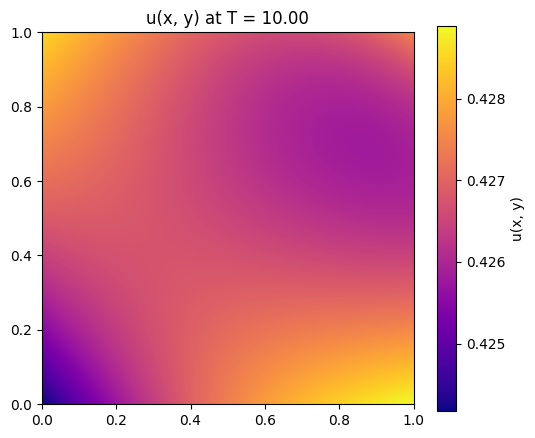

iter: 21 ###############################
    Epoch [80/800], Loss: 0.00006093
    Epoch [160/800], Loss: 0.00006055
    Epoch [240/800], Loss: 0.00006055
    Epoch [320/800], Loss: 0.00006055
    Epoch [400/800], Loss: 0.00006054
    Epoch [480/800], Loss: 0.00006054
    Epoch [560/800], Loss: 0.00006054
    Epoch [640/800], Loss: 0.00006054
    Epoch [720/800], Loss: 0.00006054
    Epoch [800/800], Loss: 0.00006054
    Energy after iteration 21: 0.182137


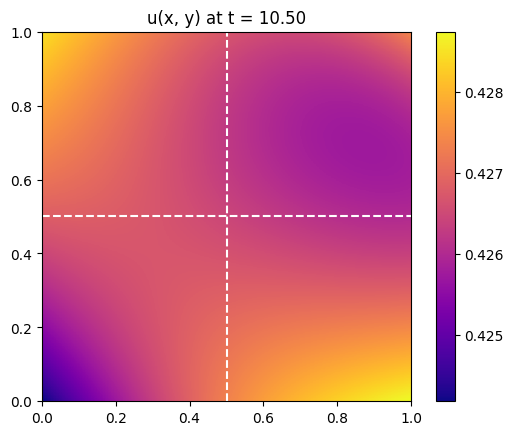

RHS max: 7.7547e-03, min: -6.1123e-03, mean: 2.5173e-04
iter: 22 ###############################
    Epoch [80/800], Loss: -0.00004415
    Epoch [160/800], Loss: -0.00004472
    Epoch [240/800], Loss: -0.00004472
    Epoch [320/800], Loss: -0.00004472
    Epoch [400/800], Loss: -0.00004472
    Epoch [480/800], Loss: -0.00004472
    Epoch [560/800], Loss: -0.00004472
    Epoch [640/800], Loss: -0.00004472
    Epoch [720/800], Loss: -0.00004472
    Epoch [800/800], Loss: -0.00004473
    Energy after iteration 22: 0.182068


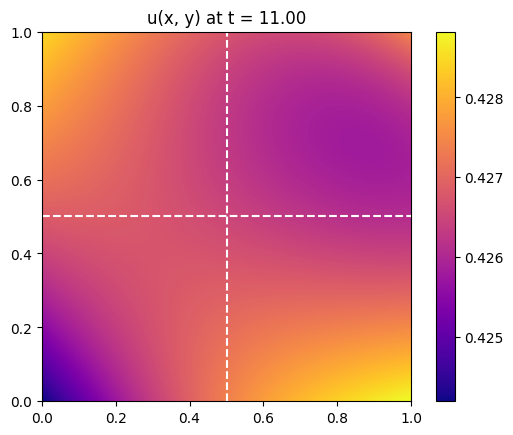

RHS max: 7.7075e-03, min: -6.3689e-03, mean: 9.2963e-05
iter: 23 ###############################
    Epoch [80/800], Loss: 0.00004601
    Epoch [160/800], Loss: 0.00004554
    Epoch [240/800], Loss: 0.00004554
    Epoch [320/800], Loss: 0.00004554
    Epoch [400/800], Loss: 0.00004554
    Epoch [480/800], Loss: 0.00004554
    Epoch [560/800], Loss: 0.00004554
    Epoch [640/800], Loss: 0.00004554
    Epoch [720/800], Loss: 0.00004554
    Epoch [800/800], Loss: 0.00004554
    Energy after iteration 23: 0.182127


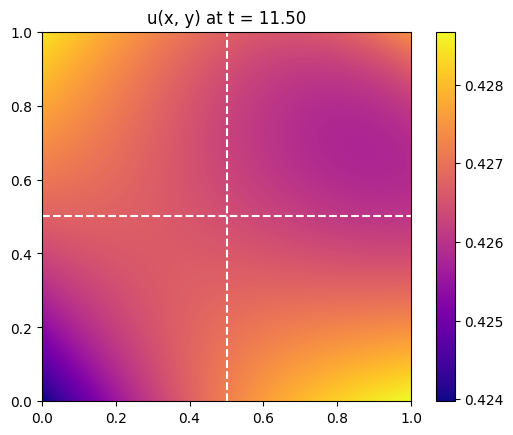

RHS max: 8.3818e-03, min: -5.9108e-03, mean: 3.2484e-04
iter: 24 ###############################
    Epoch [80/800], Loss: -0.00003128
    Epoch [160/800], Loss: -0.00003194
    Epoch [240/800], Loss: -0.00003194
    Epoch [320/800], Loss: -0.00003194
    Epoch [400/800], Loss: -0.00003194
    Epoch [480/800], Loss: -0.00003194
    Epoch [560/800], Loss: -0.00003194
    Epoch [640/800], Loss: -0.00003194
    Epoch [720/800], Loss: -0.00003195
    Epoch [800/800], Loss: -0.00003195
    Energy after iteration 24: 0.182076


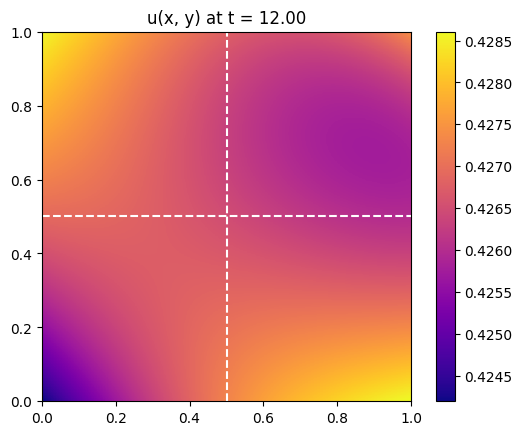

RHS max: 7.7111e-03, min: -5.7069e-03, mean: 1.6058e-04
iter: 25 ###############################
    Epoch [80/800], Loss: 0.00002394
    Epoch [160/800], Loss: 0.00002342
    Epoch [240/800], Loss: 0.00002342
    Epoch [320/800], Loss: 0.00002342
    Epoch [400/800], Loss: 0.00002342
    Epoch [480/800], Loss: 0.00002342
    Epoch [560/800], Loss: 0.00002341
    Epoch [640/800], Loss: 0.00002341
    Epoch [720/800], Loss: 0.00002341
    Epoch [800/800], Loss: 0.00002341
    Energy after iteration 25: 0.182112


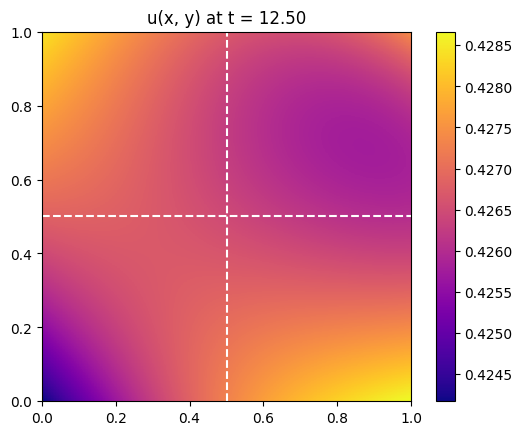

RHS max: 7.7868e-03, min: -5.8889e-03, mean: 2.4426e-04
iter: 26 ###############################
    Epoch [80/800], Loss: 0.00000029
    Epoch [160/800], Loss: -0.00000010
    Epoch [240/800], Loss: -0.00000011
    Epoch [320/800], Loss: -0.00000011
    Epoch [400/800], Loss: -0.00000011
    Epoch [480/800], Loss: -0.00000011
    Epoch [560/800], Loss: -0.00000011
    Epoch [640/800], Loss: -0.00000012
    Epoch [720/800], Loss: -0.00000012
    Epoch [800/800], Loss: -0.00000012
    Energy after iteration 26: 0.182097


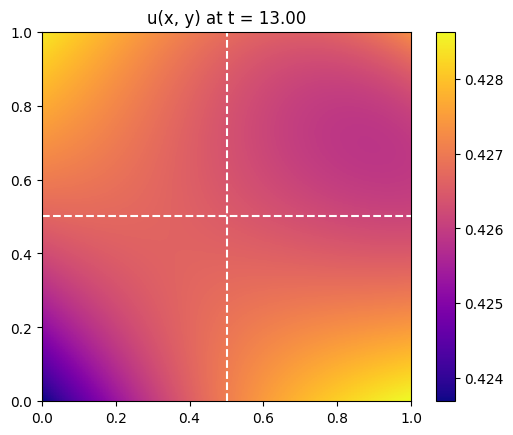

RHS max: 9.2467e-03, min: -5.7803e-03, mean: 3.1553e-04
iter: 27 ###############################
    Epoch [80/800], Loss: -0.00005507
    Epoch [160/800], Loss: -0.00005581
    Epoch [240/800], Loss: -0.00005581
    Epoch [320/800], Loss: -0.00005581
    Epoch [400/800], Loss: -0.00005581
    Epoch [480/800], Loss: -0.00005581
    Epoch [560/800], Loss: -0.00005582
    Epoch [640/800], Loss: -0.00005582
    Epoch [720/800], Loss: -0.00005582
    Epoch [800/800], Loss: -0.00005582
    Energy after iteration 27: 0.182060


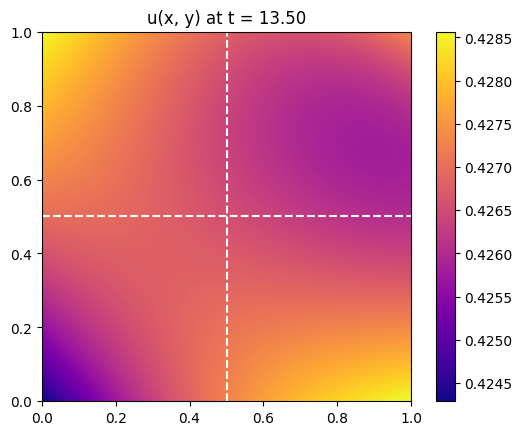

RHS max: 7.4205e-03, min: -5.5880e-03, mean: 2.0232e-05
iter: 28 ###############################
    Epoch [80/800], Loss: 0.00006324
    Epoch [160/800], Loss: 0.00006264
    Epoch [240/800], Loss: 0.00006264
    Epoch [320/800], Loss: 0.00006264
    Epoch [400/800], Loss: 0.00006264
    Epoch [480/800], Loss: 0.00006264
    Epoch [560/800], Loss: 0.00006263
    Epoch [640/800], Loss: 0.00006263
    Epoch [720/800], Loss: 0.00006263
    Epoch [800/800], Loss: 0.00006263
    Energy after iteration 28: 0.182138


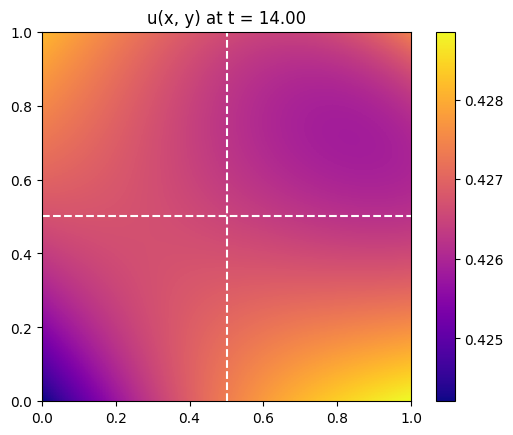

RHS max: 7.6578e-03, min: -6.4533e-03, mean: 2.1207e-04
iter: 29 ###############################
    Epoch [80/800], Loss: -0.00001973
    Epoch [160/800], Loss: -0.00002051
    Epoch [240/800], Loss: -0.00002051
    Epoch [320/800], Loss: -0.00002051
    Epoch [400/800], Loss: -0.00002051
    Epoch [480/800], Loss: -0.00002051
    Epoch [560/800], Loss: -0.00002051
    Epoch [640/800], Loss: -0.00002051
    Epoch [720/800], Loss: -0.00002051
    Epoch [800/800], Loss: -0.00002052
    Energy after iteration 29: 0.182084


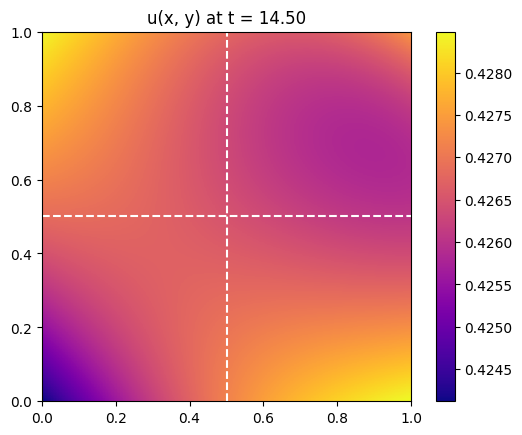

RHS max: 7.9312e-03, min: -5.3321e-03, mean: 2.3740e-04
iter: 30 ###############################
    Epoch [80/800], Loss: -0.00003323
    Epoch [160/800], Loss: -0.00003404
    Epoch [240/800], Loss: -0.00003404
    Epoch [320/800], Loss: -0.00003405
    Epoch [400/800], Loss: -0.00003405
    Epoch [480/800], Loss: -0.00003405
    Epoch [560/800], Loss: -0.00003405
    Epoch [640/800], Loss: -0.00003405
    Epoch [720/800], Loss: -0.00003405
    Epoch [800/800], Loss: -0.00003405
    Energy after iteration 30: 0.182075


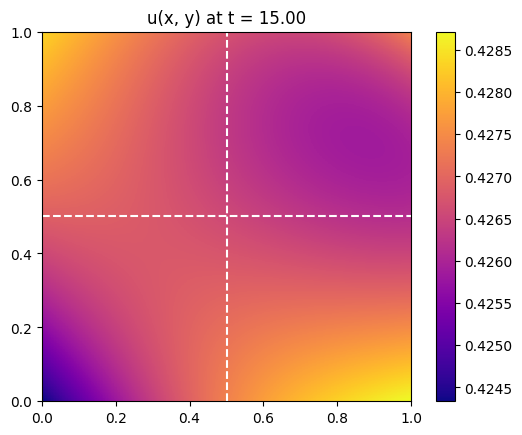

RHS max: 7.2798e-03, min: -6.0380e-03, mean: 2.0137e-05


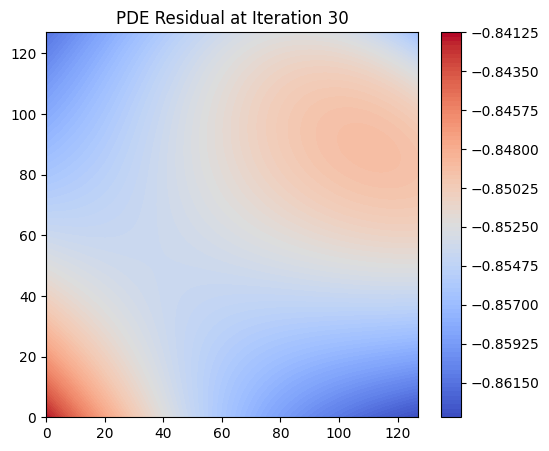

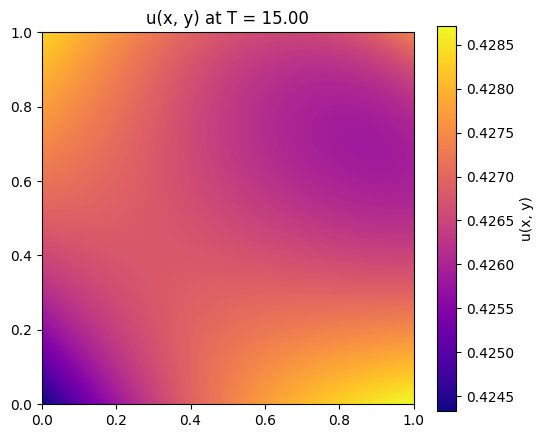

iter: 31 ###############################
    Epoch [80/800], Loss: 0.00006131
    Epoch [160/800], Loss: 0.00006063
    Epoch [240/800], Loss: 0.00006063
    Epoch [320/800], Loss: 0.00006063
    Epoch [400/800], Loss: 0.00006063
    Epoch [480/800], Loss: 0.00006063
    Epoch [560/800], Loss: 0.00006063
    Epoch [640/800], Loss: 0.00006063
    Epoch [720/800], Loss: 0.00006063
    Epoch [800/800], Loss: 0.00006062
    Energy after iteration 31: 0.182137


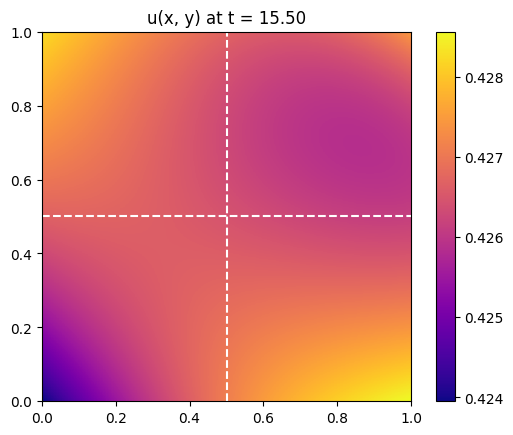

RHS max: 8.4438e-03, min: -5.5704e-03, mean: 3.7394e-04
iter: 32 ###############################
    Epoch [80/800], Loss: -0.00003697
    Epoch [160/800], Loss: -0.00003782
    Epoch [240/800], Loss: -0.00003782
    Epoch [320/800], Loss: -0.00003782
    Epoch [400/800], Loss: -0.00003782
    Epoch [480/800], Loss: -0.00003782
    Epoch [560/800], Loss: -0.00003782
    Epoch [640/800], Loss: -0.00003782
    Epoch [720/800], Loss: -0.00003782
    Epoch [800/800], Loss: -0.00003782
    Energy after iteration 32: 0.182072


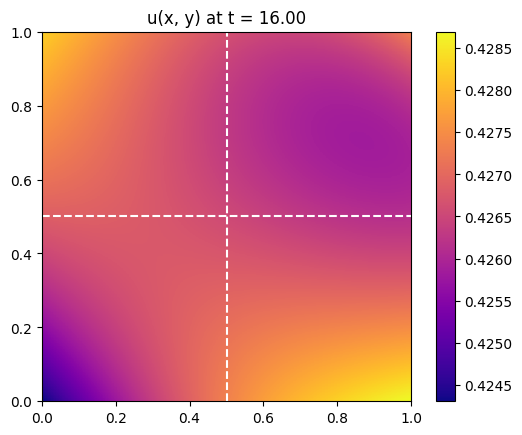

RHS max: 7.3667e-03, min: -5.9739e-03, mean: 9.4849e-05
iter: 33 ###############################
    Epoch [80/800], Loss: 0.00001662
    Epoch [160/800], Loss: 0.00001591
    Epoch [240/800], Loss: 0.00001591
    Epoch [320/800], Loss: 0.00001591
    Epoch [400/800], Loss: 0.00001591
    Epoch [480/800], Loss: 0.00001591
    Epoch [560/800], Loss: 0.00001590
    Epoch [640/800], Loss: 0.00001590
    Epoch [720/800], Loss: 0.00001590
    Epoch [800/800], Loss: 0.00001590
    Energy after iteration 33: 0.182107


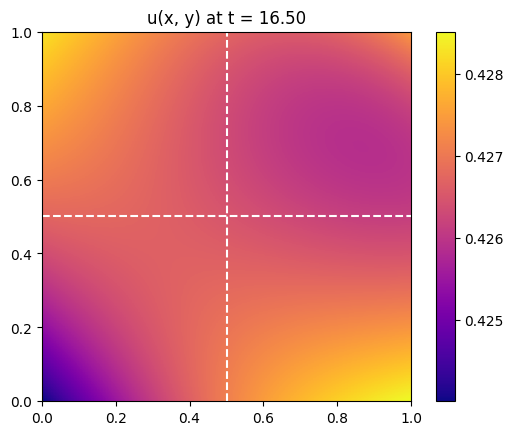

RHS max: 8.2920e-03, min: -5.4507e-03, mean: 2.8984e-04
iter: 34 ###############################
    Epoch [80/800], Loss: 0.00000566
    Epoch [160/800], Loss: 0.00000509
    Epoch [240/800], Loss: 0.00000509
    Epoch [320/800], Loss: 0.00000509
    Epoch [400/800], Loss: 0.00000509
    Epoch [480/800], Loss: 0.00000509
    Epoch [560/800], Loss: 0.00000509
    Epoch [640/800], Loss: 0.00000509
    Epoch [720/800], Loss: 0.00000509
    Epoch [800/800], Loss: 0.00000509
    Energy after iteration 34: 0.182100


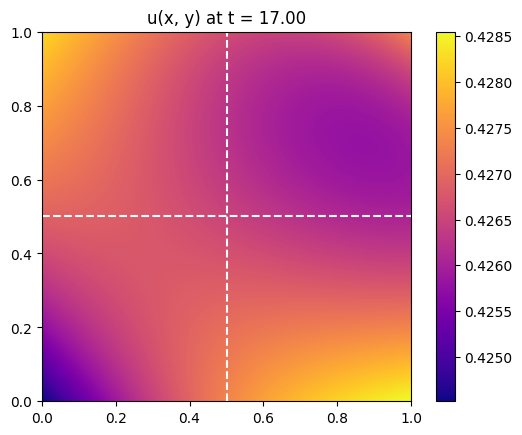

RHS max: 6.7292e-03, min: -5.5379e-03, mean: 1.8029e-04
iter: 35 ###############################
    Epoch [80/800], Loss: -0.00002679
    Epoch [160/800], Loss: -0.00002768
    Epoch [240/800], Loss: -0.00002768
    Epoch [320/800], Loss: -0.00002768
    Epoch [400/800], Loss: -0.00002768
    Epoch [480/800], Loss: -0.00002768
    Epoch [560/800], Loss: -0.00002768
    Epoch [640/800], Loss: -0.00002768
    Epoch [720/800], Loss: -0.00002768
    Epoch [800/800], Loss: -0.00002768
    Energy after iteration 35: 0.182079


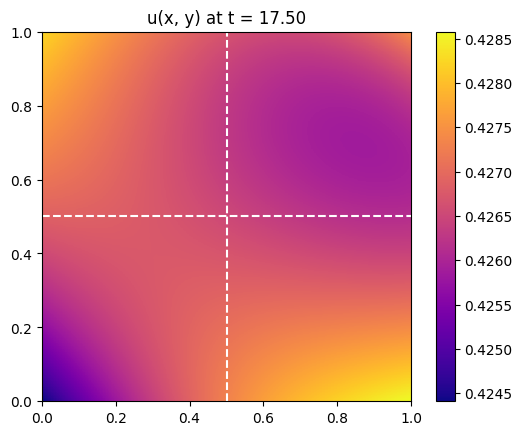

RHS max: 7.0518e-03, min: -5.6245e-03, mean: 1.3031e-04
iter: 36 ###############################
    Epoch [80/800], Loss: 0.00001002
    Epoch [160/800], Loss: 0.00000924
    Epoch [240/800], Loss: 0.00000924
    Epoch [320/800], Loss: 0.00000924
    Epoch [400/800], Loss: 0.00000924
    Epoch [480/800], Loss: 0.00000924
    Epoch [560/800], Loss: 0.00000924
    Epoch [640/800], Loss: 0.00000924
    Epoch [720/800], Loss: 0.00000923
    Epoch [800/800], Loss: 0.00000923
    Energy after iteration 36: 0.182103


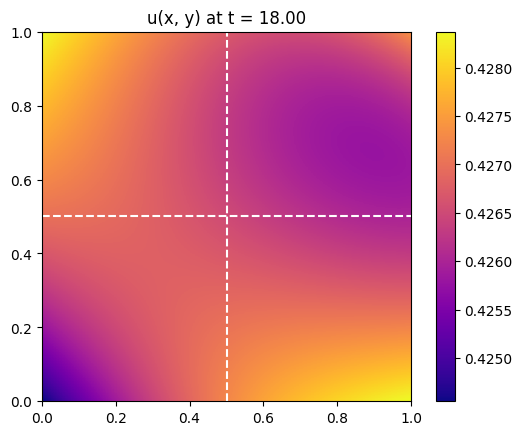

RHS max: 6.6215e-03, min: -4.9943e-03, mean: 1.4296e-04
iter: 37 ###############################
    Epoch [80/800], Loss: -0.00000249
    Epoch [160/800], Loss: -0.00000314
    Epoch [240/800], Loss: -0.00000314
    Epoch [320/800], Loss: -0.00000315
    Epoch [400/800], Loss: -0.00000315
    Epoch [480/800], Loss: -0.00000315
    Epoch [560/800], Loss: -0.00000315
    Epoch [640/800], Loss: -0.00000315
    Epoch [720/800], Loss: -0.00000315
    Epoch [800/800], Loss: -0.00000315
    Energy after iteration 37: 0.182095


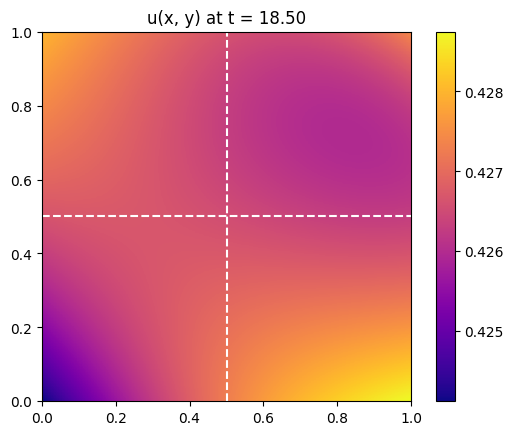

RHS max: 7.9303e-03, min: -6.1412e-03, mean: 1.7818e-04
iter: 38 ###############################
    Epoch [80/800], Loss: 0.00001064
    Epoch [160/800], Loss: 0.00000982
    Epoch [240/800], Loss: 0.00000982
    Epoch [320/800], Loss: 0.00000982
    Epoch [400/800], Loss: 0.00000982
    Epoch [480/800], Loss: 0.00000982
    Epoch [560/800], Loss: 0.00000981
    Epoch [640/800], Loss: 0.00000981
    Epoch [720/800], Loss: 0.00000981
    Epoch [800/800], Loss: 0.00000981
    Energy after iteration 38: 0.182103


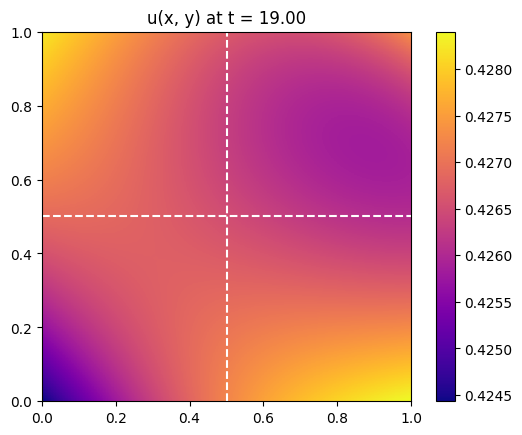

RHS max: 6.9878e-03, min: -5.0908e-03, mean: 1.9034e-04
iter: 39 ###############################
    Epoch [80/800], Loss: -0.00002700
    Epoch [160/800], Loss: -0.00002791
    Epoch [240/800], Loss: -0.00002791
    Epoch [320/800], Loss: -0.00002791
    Epoch [400/800], Loss: -0.00002791
    Epoch [480/800], Loss: -0.00002791
    Epoch [560/800], Loss: -0.00002791
    Epoch [640/800], Loss: -0.00002791
    Epoch [720/800], Loss: -0.00002791
    Epoch [800/800], Loss: -0.00002792
    Energy after iteration 39: 0.182079


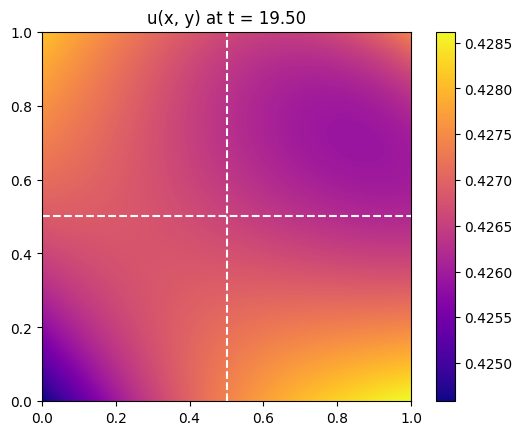

RHS max: 6.5282e-03, min: -5.7523e-03, mean: 3.5239e-05
iter: 40 ###############################
    Epoch [80/800], Loss: 0.00004410
    Epoch [160/800], Loss: 0.00004323
    Epoch [240/800], Loss: 0.00004323
    Epoch [320/800], Loss: 0.00004323
    Epoch [400/800], Loss: 0.00004323
    Epoch [480/800], Loss: 0.00004323
    Epoch [560/800], Loss: 0.00004323
    Epoch [640/800], Loss: 0.00004323
    Epoch [720/800], Loss: 0.00004323
    Epoch [800/800], Loss: 0.00004323
    Energy after iteration 40: 0.182125


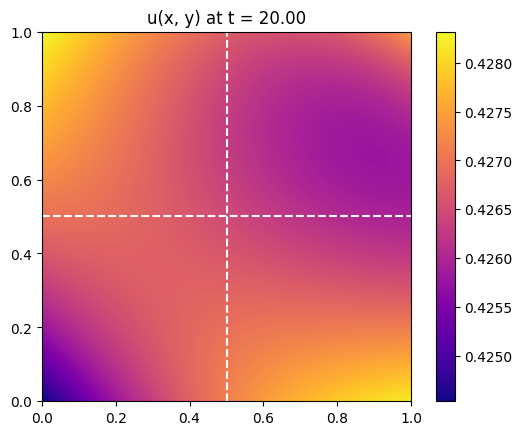

RHS max: 6.6813e-03, min: -4.8391e-03, mean: 2.6263e-04


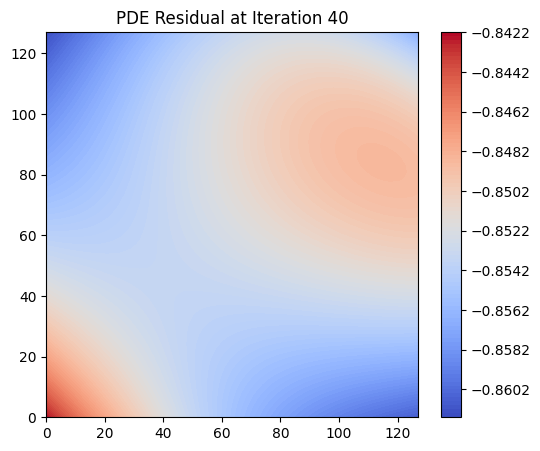

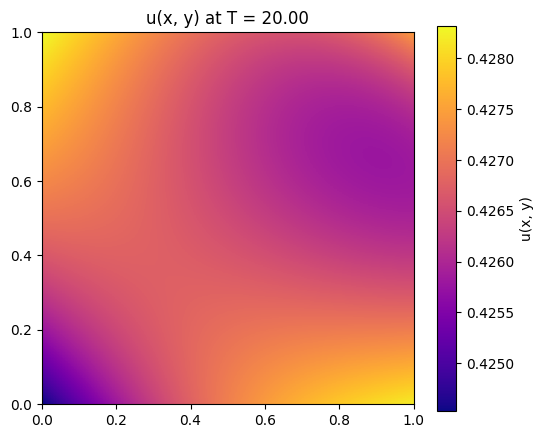

iter: 41 ###############################
    Epoch [80/800], Loss: -0.00002301
    Epoch [160/800], Loss: -0.00002393
    Epoch [240/800], Loss: -0.00002394
    Epoch [320/800], Loss: -0.00002394
    Epoch [400/800], Loss: -0.00002394
    Epoch [480/800], Loss: -0.00002394
    Epoch [560/800], Loss: -0.00002394
    Epoch [640/800], Loss: -0.00002394
    Epoch [720/800], Loss: -0.00002394
    Epoch [800/800], Loss: -0.00002395
    Energy after iteration 41: 0.182081


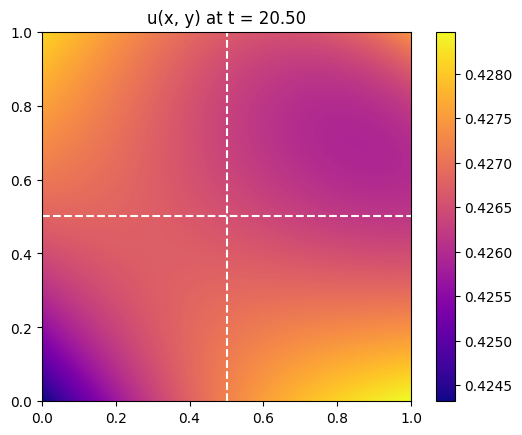

RHS max: 7.3258e-03, min: -5.3023e-03, mean: 1.7582e-04
iter: 42 ###############################
    Epoch [80/800], Loss: 0.00000781
    Epoch [160/800], Loss: 0.00000693
    Epoch [240/800], Loss: 0.00000693
    Epoch [320/800], Loss: 0.00000693
    Epoch [400/800], Loss: 0.00000693
    Epoch [480/800], Loss: 0.00000693
    Epoch [560/800], Loss: 0.00000693
    Epoch [640/800], Loss: 0.00000693
    Epoch [720/800], Loss: 0.00000692
    Epoch [800/800], Loss: 0.00000692
    Energy after iteration 42: 0.182102


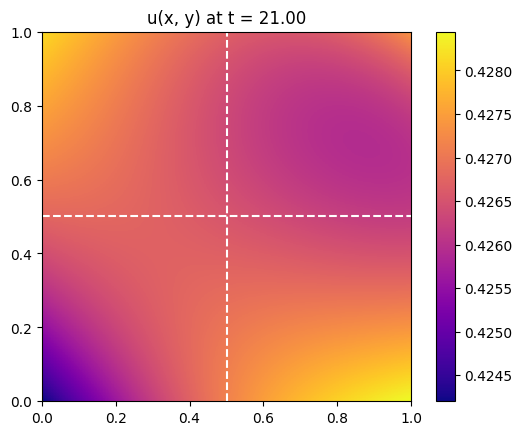

RHS max: 7.6904e-03, min: -5.2188e-03, mean: 2.1294e-04
iter: 43 ###############################
    Epoch [80/800], Loss: 0.00000301
    Epoch [160/800], Loss: 0.00000296
    Epoch [240/800], Loss: 0.00000296
    Epoch [320/800], Loss: 0.00000296
    Epoch [400/800], Loss: 0.00000296
    Epoch [480/800], Loss: 0.00000296
    Epoch [560/800], Loss: 0.00000296
    Epoch [640/800], Loss: 0.00000296
    Epoch [720/800], Loss: 0.00000296
    Epoch [800/800], Loss: 0.00000295
    Energy after iteration 43: 0.182099


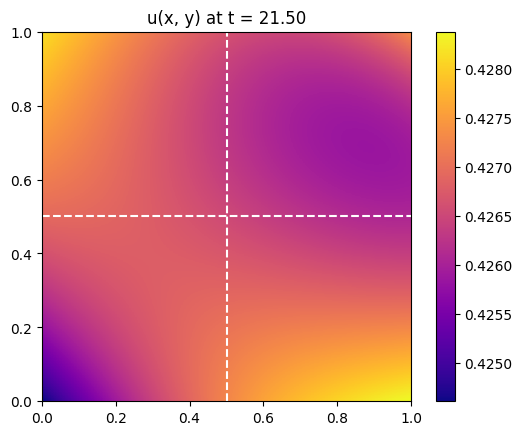

RHS max: 6.4339e-03, min: -5.0246e-03, mean: 1.4513e-04
iter: 44 ###############################
    Epoch [80/800], Loss: -0.00000081
    Epoch [160/800], Loss: -0.00000149
    Epoch [240/800], Loss: -0.00000149
    Epoch [320/800], Loss: -0.00000149
    Epoch [400/800], Loss: -0.00000149
    Epoch [480/800], Loss: -0.00000149
    Epoch [560/800], Loss: -0.00000149
    Epoch [640/800], Loss: -0.00000149
    Epoch [720/800], Loss: -0.00000150
    Epoch [800/800], Loss: -0.00000150
    Energy after iteration 44: 0.182096


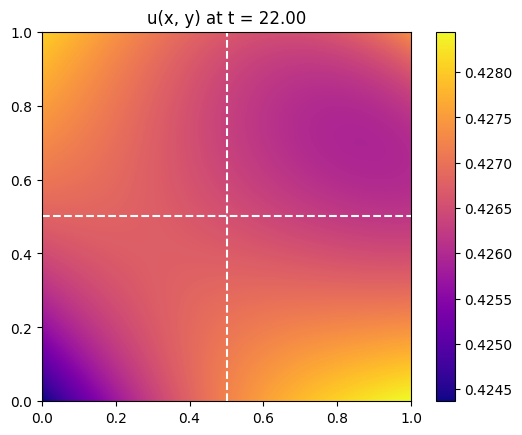

RHS max: 7.1835e-03, min: -5.2240e-03, mean: 1.8080e-04
iter: 45 ###############################
    Epoch [80/800], Loss: -0.00000836
    Epoch [160/800], Loss: -0.00000927
    Epoch [240/800], Loss: -0.00000927
    Epoch [320/800], Loss: -0.00000927
    Epoch [400/800], Loss: -0.00000927
    Epoch [480/800], Loss: -0.00000927
    Epoch [560/800], Loss: -0.00000927
    Epoch [640/800], Loss: -0.00000927
    Epoch [720/800], Loss: -0.00000927
    Epoch [800/800], Loss: -0.00000927
    Energy after iteration 45: 0.182091


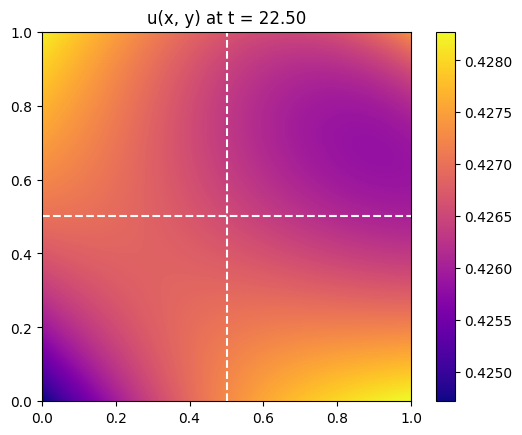

RHS max: 6.1202e-03, min: -4.7074e-03, mean: 1.0081e-04
iter: 46 ###############################
    Epoch [80/800], Loss: 0.00000990
    Epoch [160/800], Loss: 0.00000900
    Epoch [240/800], Loss: 0.00000900
    Epoch [320/800], Loss: 0.00000900
    Epoch [400/800], Loss: 0.00000900
    Epoch [480/800], Loss: 0.00000900
    Epoch [560/800], Loss: 0.00000900
    Epoch [640/800], Loss: 0.00000900
    Epoch [720/800], Loss: 0.00000900
    Epoch [800/800], Loss: 0.00000900
    Energy after iteration 46: 0.182103


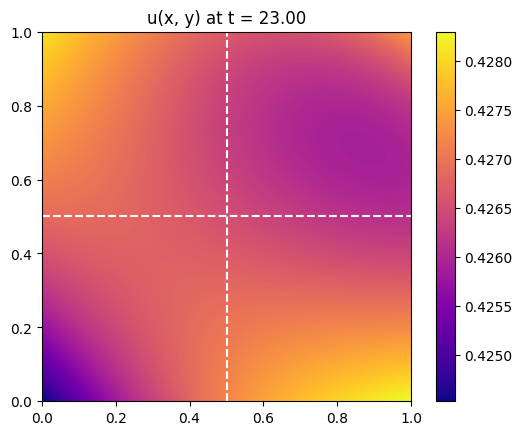

RHS max: 6.6840e-03, min: -4.7624e-03, mean: 2.0279e-04
iter: 47 ###############################
    Epoch [80/800], Loss: -0.00000742
    Epoch [160/800], Loss: -0.00000831
    Epoch [240/800], Loss: -0.00000831
    Epoch [320/800], Loss: -0.00000831
    Epoch [400/800], Loss: -0.00000831
    Epoch [480/800], Loss: -0.00000831
    Epoch [560/800], Loss: -0.00000831
    Epoch [640/800], Loss: -0.00000831
    Epoch [720/800], Loss: -0.00000831
    Epoch [800/800], Loss: -0.00000831
    Energy after iteration 47: 0.182091


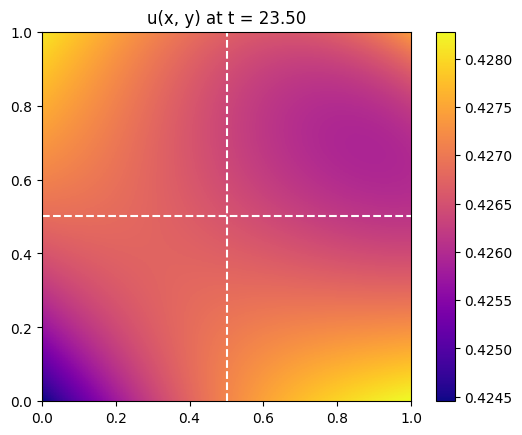

RHS max: 6.9194e-03, min: -4.7154e-03, mean: 1.8822e-04
iter: 48 ###############################
    Epoch [80/800], Loss: 0.00001135
    Epoch [160/800], Loss: 0.00001046
    Epoch [240/800], Loss: 0.00001046
    Epoch [320/800], Loss: 0.00001046
    Epoch [400/800], Loss: 0.00001046
    Epoch [480/800], Loss: 0.00001046
    Epoch [560/800], Loss: 0.00001046
    Epoch [640/800], Loss: 0.00001045
    Epoch [720/800], Loss: 0.00001045
    Epoch [800/800], Loss: 0.00001045
    Energy after iteration 48: 0.182104


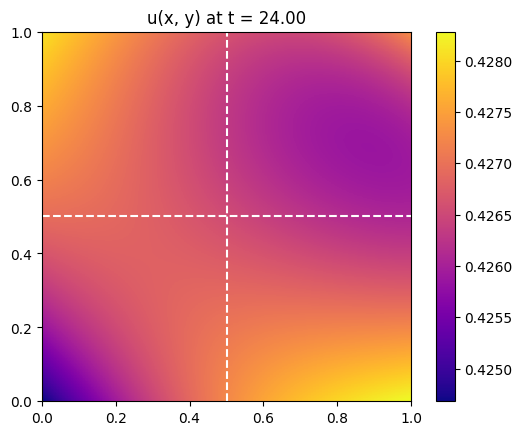

RHS max: 6.2273e-03, min: -4.7227e-03, mean: 1.4725e-04
iter: 49 ###############################
    Epoch [80/800], Loss: -0.00001134
    Epoch [160/800], Loss: -0.00001219
    Epoch [240/800], Loss: -0.00001219
    Epoch [320/800], Loss: -0.00001219
    Epoch [400/800], Loss: -0.00001219
    Epoch [480/800], Loss: -0.00001219
    Epoch [560/800], Loss: -0.00001219
    Epoch [640/800], Loss: -0.00001219
    Epoch [720/800], Loss: -0.00001219
    Epoch [800/800], Loss: -0.00001219
    Energy after iteration 49: 0.182089


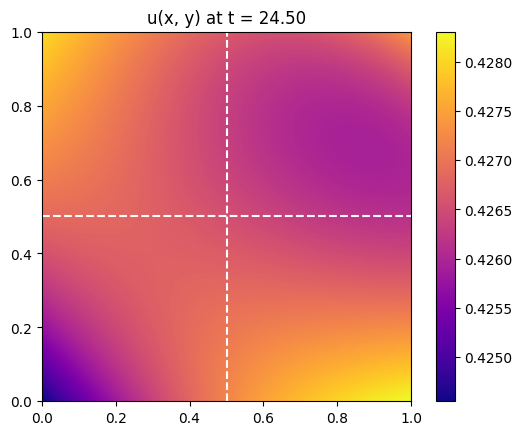

RHS max: 6.6133e-03, min: -4.7868e-03, mean: 1.6096e-04
iter: 50 ###############################
    Epoch [80/800], Loss: 0.00000952
    Epoch [160/800], Loss: 0.00000864
    Epoch [240/800], Loss: 0.00000864
    Epoch [320/800], Loss: 0.00000864
    Epoch [400/800], Loss: 0.00000864
    Epoch [480/800], Loss: 0.00000864
    Epoch [560/800], Loss: 0.00000864
    Epoch [640/800], Loss: 0.00000864
    Epoch [720/800], Loss: 0.00000863
    Epoch [800/800], Loss: 0.00000863
    Energy after iteration 50: 0.182103


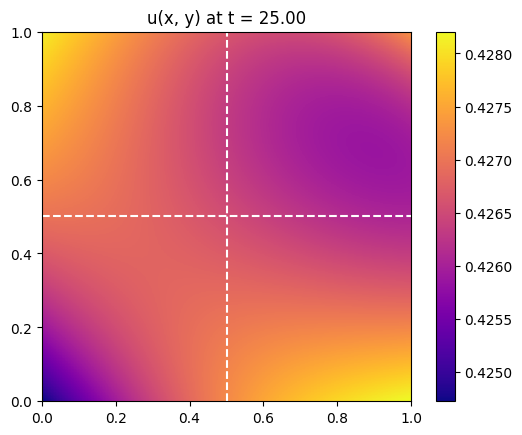

RHS max: 6.1052e-03, min: -4.4909e-03, mean: 1.4438e-04


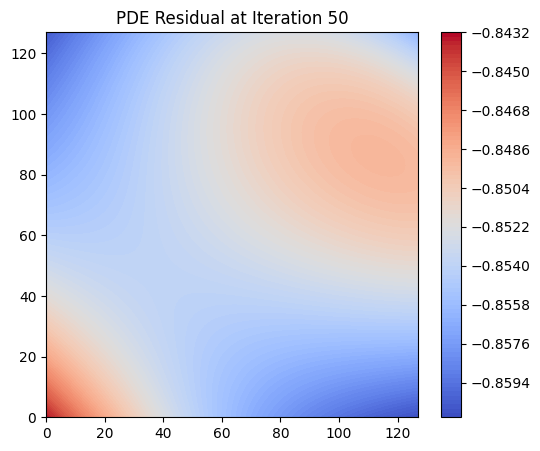

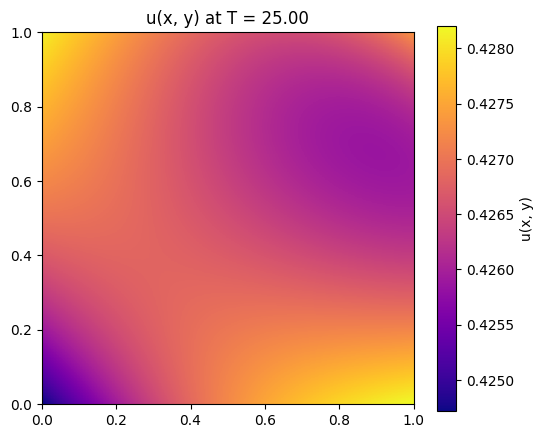

iter: 51 ###############################
    Epoch [80/800], Loss: -0.00001624
    Epoch [160/800], Loss: -0.00001708
    Epoch [240/800], Loss: -0.00001708
    Epoch [320/800], Loss: -0.00001708
    Epoch [400/800], Loss: -0.00001708
    Epoch [480/800], Loss: -0.00001708
    Epoch [560/800], Loss: -0.00001708
    Epoch [640/800], Loss: -0.00001708
    Epoch [720/800], Loss: -0.00001708
    Epoch [800/800], Loss: -0.00001708
    Energy after iteration 51: 0.182086


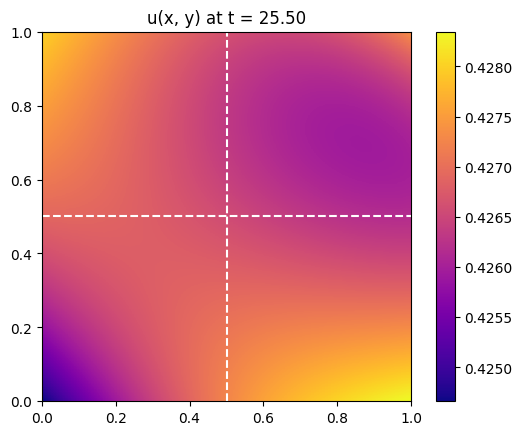

RHS max: 6.2855e-03, min: -4.9180e-03, mean: 9.1620e-05
iter: 52 ###############################
    Epoch [80/800], Loss: 0.00003335
    Epoch [160/800], Loss: 0.00003250
    Epoch [240/800], Loss: 0.00003249
    Epoch [320/800], Loss: 0.00003249
    Epoch [400/800], Loss: 0.00003249
    Epoch [480/800], Loss: 0.00003249
    Epoch [560/800], Loss: 0.00003249
    Epoch [640/800], Loss: 0.00003249
    Epoch [720/800], Loss: 0.00003249
    Epoch [800/800], Loss: 0.00003249
    Energy after iteration 52: 0.182118


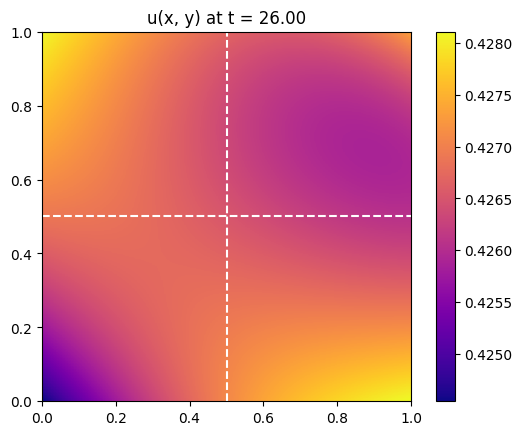

RHS max: 6.6487e-03, min: -4.1984e-03, mean: 2.6286e-04
iter: 53 ###############################
    Epoch [80/800], Loss: -0.00002194
    Epoch [160/800], Loss: -0.00002276
    Epoch [240/800], Loss: -0.00002276
    Epoch [320/800], Loss: -0.00002276
    Epoch [400/800], Loss: -0.00002276
    Epoch [480/800], Loss: -0.00002276
    Epoch [560/800], Loss: -0.00002276
    Epoch [640/800], Loss: -0.00002276
    Epoch [720/800], Loss: -0.00002276
    Epoch [800/800], Loss: -0.00002276
    Energy after iteration 53: 0.182082


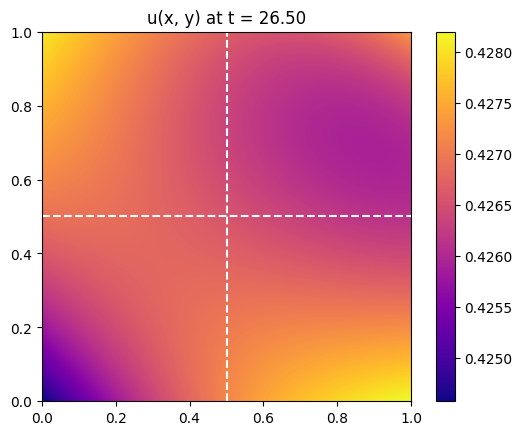

RHS max: 6.5569e-03, min: -4.4749e-03, mean: 1.5800e-04
iter: 54 ###############################
    Epoch [80/800], Loss: -0.00001303
    Epoch [160/800], Loss: -0.00001385
    Epoch [240/800], Loss: -0.00001385
    Epoch [320/800], Loss: -0.00001385
    Epoch [400/800], Loss: -0.00001385
    Epoch [480/800], Loss: -0.00001385
    Epoch [560/800], Loss: -0.00001386
    Epoch [640/800], Loss: -0.00001386
    Epoch [720/800], Loss: -0.00001386
    Epoch [800/800], Loss: -0.00001386
    Energy after iteration 54: 0.182088


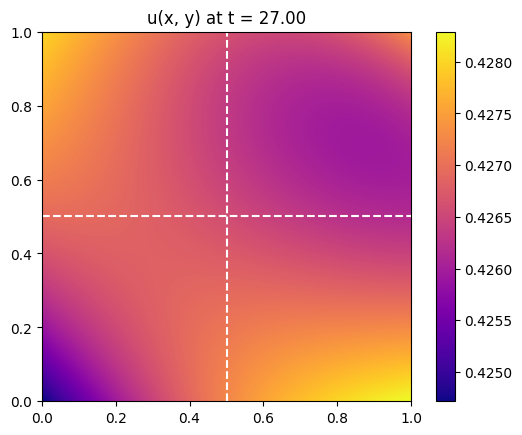

RHS max: 6.1160e-03, min: -4.7460e-03, mean: 6.7483e-05
iter: 55 ###############################
    Epoch [80/800], Loss: 0.00004983
    Epoch [160/800], Loss: 0.00004903
    Epoch [240/800], Loss: 0.00004903
    Epoch [320/800], Loss: 0.00004903
    Epoch [400/800], Loss: 0.00004903
    Epoch [480/800], Loss: 0.00004903
    Epoch [560/800], Loss: 0.00004903
    Epoch [640/800], Loss: 0.00004903
    Epoch [720/800], Loss: 0.00004903
    Epoch [800/800], Loss: 0.00004903
    Energy after iteration 55: 0.182129


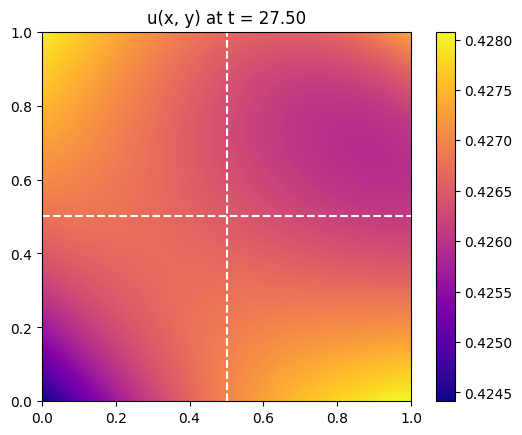

RHS max: 7.0465e-03, min: -4.1026e-03, mean: 3.5385e-04
iter: 56 ###############################
    Epoch [80/800], Loss: -0.00004690
    Epoch [160/800], Loss: -0.00004770
    Epoch [240/800], Loss: -0.00004770
    Epoch [320/800], Loss: -0.00004770
    Epoch [400/800], Loss: -0.00004770
    Epoch [480/800], Loss: -0.00004770
    Epoch [560/800], Loss: -0.00004770
    Epoch [640/800], Loss: -0.00004770
    Epoch [720/800], Loss: -0.00004770
    Epoch [800/800], Loss: -0.00004770
    Energy after iteration 56: 0.182065


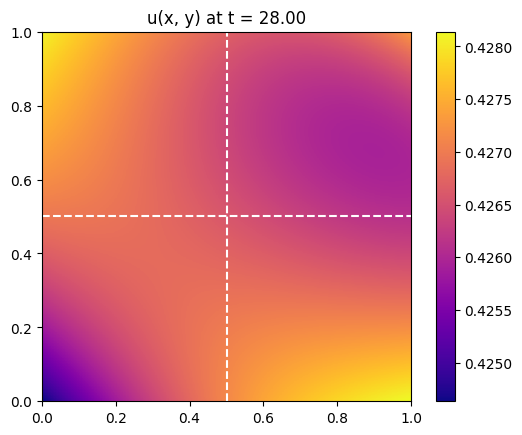

RHS max: 6.3727e-03, min: -4.2907e-03, mean: 1.0888e-04
iter: 57 ###############################
    Epoch [80/800], Loss: 0.00004415
    Epoch [160/800], Loss: 0.00004338
    Epoch [240/800], Loss: 0.00004338
    Epoch [320/800], Loss: 0.00004338
    Epoch [400/800], Loss: 0.00004338
    Epoch [480/800], Loss: 0.00004338
    Epoch [560/800], Loss: 0.00004338
    Epoch [640/800], Loss: 0.00004338
    Epoch [720/800], Loss: 0.00004338
    Epoch [800/800], Loss: 0.00004338
    Energy after iteration 57: 0.182125


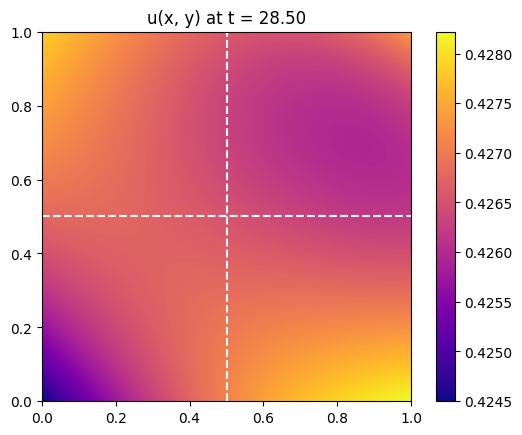

RHS max: 6.7858e-03, min: -4.5352e-03, mean: 2.9178e-04
iter: 58 ###############################
    Epoch [80/800], Loss: -0.00002683
    Epoch [160/800], Loss: -0.00002765
    Epoch [240/800], Loss: -0.00002765
    Epoch [320/800], Loss: -0.00002765
    Epoch [400/800], Loss: -0.00002765
    Epoch [480/800], Loss: -0.00002765
    Epoch [560/800], Loss: -0.00002765
    Epoch [640/800], Loss: -0.00002765
    Epoch [720/800], Loss: -0.00002765
    Epoch [800/800], Loss: -0.00002765
    Energy after iteration 58: 0.182079


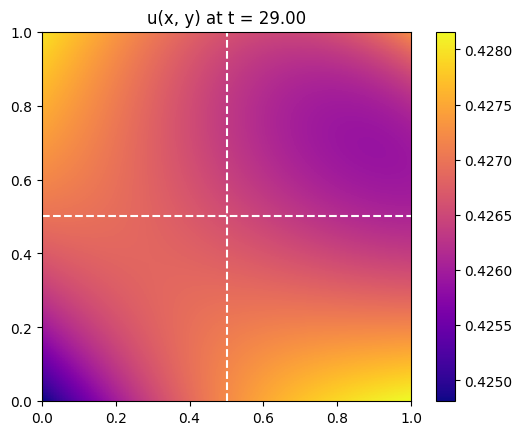

RHS max: 5.8321e-03, min: -4.3564e-03, mean: 1.2029e-04
iter: 59 ###############################
    Epoch [80/800], Loss: 0.00000571
    Epoch [160/800], Loss: 0.00000512
    Epoch [240/800], Loss: 0.00000512
    Epoch [320/800], Loss: 0.00000511
    Epoch [400/800], Loss: 0.00000511
    Epoch [480/800], Loss: 0.00000511
    Epoch [560/800], Loss: 0.00000511
    Epoch [640/800], Loss: 0.00000511
    Epoch [720/800], Loss: 0.00000511
    Epoch [800/800], Loss: 0.00000511
    Energy after iteration 59: 0.182100


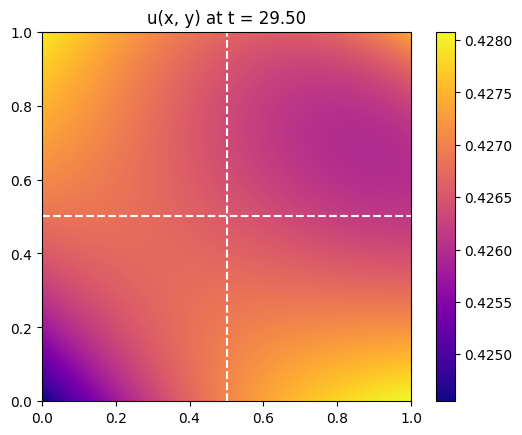

RHS max: 6.6218e-03, min: -4.1108e-03, mean: 2.5334e-04
iter: 60 ###############################
    Epoch [80/800], Loss: -0.00000396
    Epoch [160/800], Loss: -0.00000481
    Epoch [240/800], Loss: -0.00000481
    Epoch [320/800], Loss: -0.00000481
    Epoch [400/800], Loss: -0.00000481
    Epoch [480/800], Loss: -0.00000481
    Epoch [560/800], Loss: -0.00000481
    Epoch [640/800], Loss: -0.00000482
    Epoch [720/800], Loss: -0.00000482
    Epoch [800/800], Loss: -0.00000482
    Energy after iteration 60: 0.182094


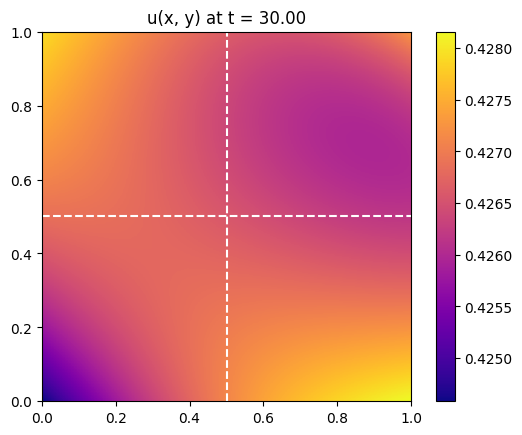

RHS max: 6.5268e-03, min: -4.3498e-03, mean: 1.7914e-04


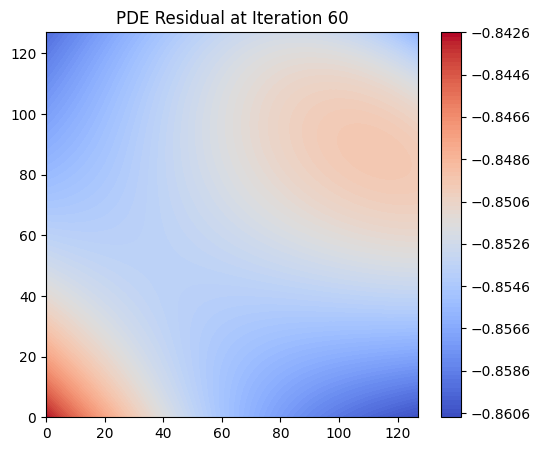

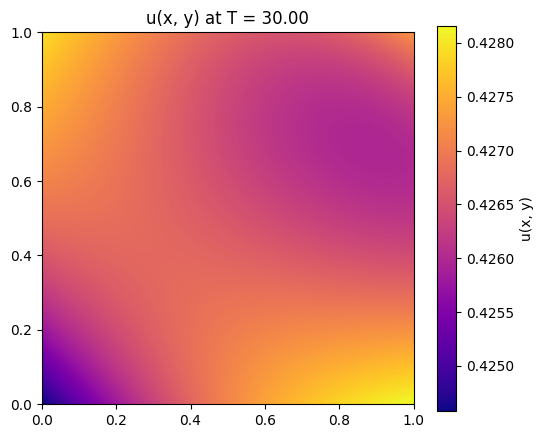

iter: 61 ###############################
    Epoch [80/800], Loss: -0.00000136
    Epoch [160/800], Loss: -0.00000219
    Epoch [240/800], Loss: -0.00000219
    Epoch [320/800], Loss: -0.00000219
    Epoch [400/800], Loss: -0.00000219
    Epoch [480/800], Loss: -0.00000219
    Epoch [560/800], Loss: -0.00000219
    Epoch [640/800], Loss: -0.00000219
    Epoch [720/800], Loss: -0.00000219
    Epoch [800/800], Loss: -0.00000219
    Energy after iteration 61: 0.182096


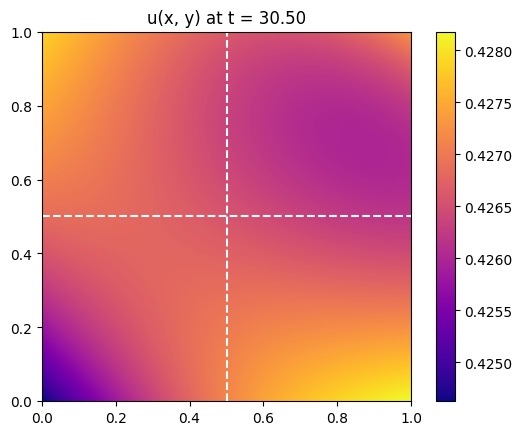

RHS max: 6.3939e-03, min: -4.4146e-03, mean: 1.6613e-04
iter: 62 ###############################
    Epoch [80/800], Loss: 0.00000249
    Epoch [160/800], Loss: 0.00000182
    Epoch [240/800], Loss: 0.00000182
    Epoch [320/800], Loss: 0.00000182
    Epoch [400/800], Loss: 0.00000182
    Epoch [480/800], Loss: 0.00000182
    Epoch [560/800], Loss: 0.00000182
    Epoch [640/800], Loss: 0.00000182
    Epoch [720/800], Loss: 0.00000182
    Epoch [800/800], Loss: 0.00000182
    Energy after iteration 62: 0.182098


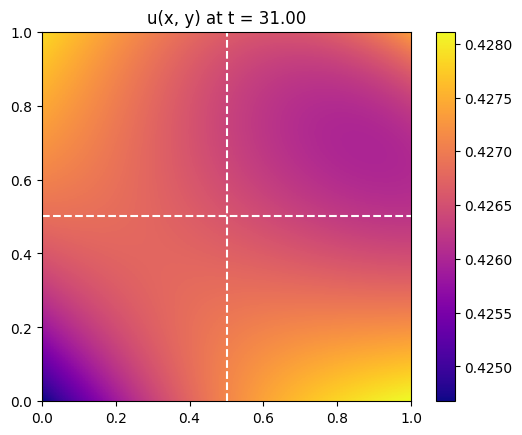

RHS max: 6.2441e-03, min: -4.2085e-03, mean: 1.8978e-04
iter: 63 ###############################
    Epoch [80/800], Loss: -0.00000816
    Epoch [160/800], Loss: -0.00000896
    Epoch [240/800], Loss: -0.00000896
    Epoch [320/800], Loss: -0.00000896
    Epoch [400/800], Loss: -0.00000896
    Epoch [480/800], Loss: -0.00000896
    Epoch [560/800], Loss: -0.00000896
    Epoch [640/800], Loss: -0.00000896
    Epoch [720/800], Loss: -0.00000896
    Epoch [800/800], Loss: -0.00000896
    Energy after iteration 63: 0.182091


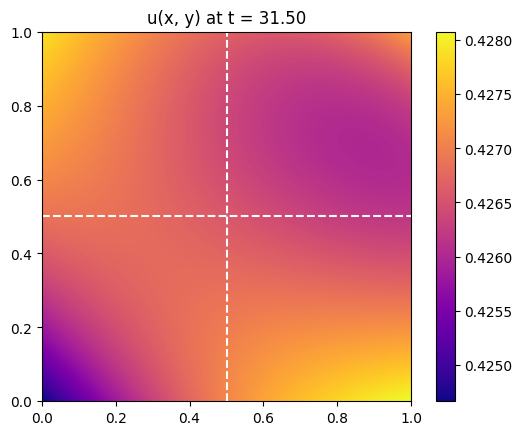

RHS max: 6.2827e-03, min: -4.1041e-03, mean: 1.6561e-04
iter: 64 ###############################
    Epoch [80/800], Loss: 0.00003717
    Epoch [160/800], Loss: 0.00003644
    Epoch [240/800], Loss: 0.00003644
    Epoch [320/800], Loss: 0.00003644
    Epoch [400/800], Loss: 0.00003643
    Epoch [480/800], Loss: 0.00003643
    Epoch [560/800], Loss: 0.00003643
    Epoch [640/800], Loss: 0.00003643
    Epoch [720/800], Loss: 0.00003643
    Epoch [800/800], Loss: 0.00003643
    Energy after iteration 64: 0.182121


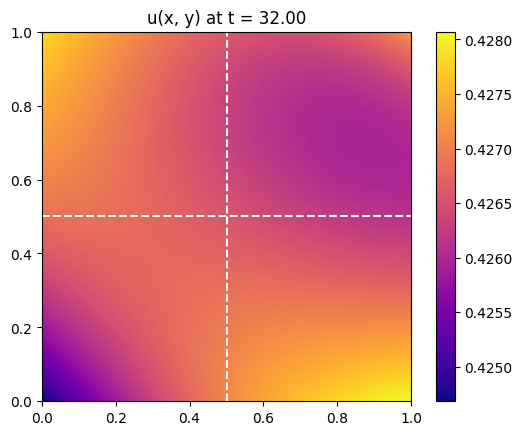

RHS max: 6.2176e-03, min: -4.0800e-03, mean: 2.5045e-04
iter: 65 ###############################
    Epoch [80/800], Loss: -0.00004352
    Epoch [160/800], Loss: -0.00004429
    Epoch [240/800], Loss: -0.00004429
    Epoch [320/800], Loss: -0.00004429
    Epoch [400/800], Loss: -0.00004429
    Epoch [480/800], Loss: -0.00004429
    Epoch [560/800], Loss: -0.00004429
    Epoch [640/800], Loss: -0.00004429
    Epoch [720/800], Loss: -0.00004429
    Epoch [800/800], Loss: -0.00004429
    Energy after iteration 65: 0.182068


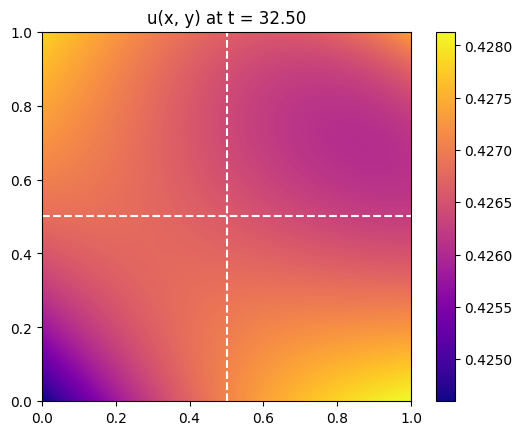

RHS max: 6.4811e-03, min: -4.2661e-03, mean: 1.4387e-04
iter: 66 ###############################
    Epoch [80/800], Loss: 0.00002268
    Epoch [160/800], Loss: 0.00002195
    Epoch [240/800], Loss: 0.00002195
    Epoch [320/800], Loss: 0.00002195
    Epoch [400/800], Loss: 0.00002195
    Epoch [480/800], Loss: 0.00002195
    Epoch [560/800], Loss: 0.00002195
    Epoch [640/800], Loss: 0.00002195
    Epoch [720/800], Loss: 0.00002195
    Epoch [800/800], Loss: 0.00002195
    Energy after iteration 66: 0.182111


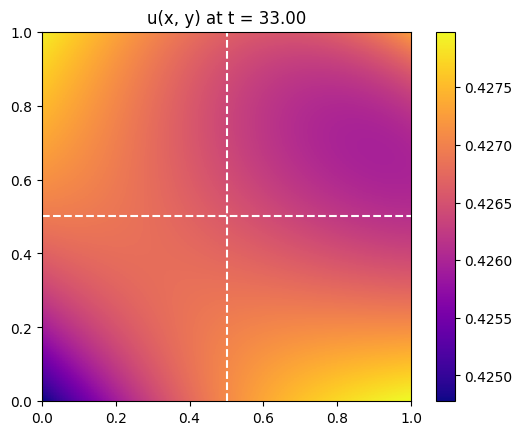

RHS max: 5.9404e-03, min: -3.8149e-03, mean: 1.7681e-04
iter: 67 ###############################
    Epoch [80/800], Loss: -0.00000769
    Epoch [160/800], Loss: -0.00000848
    Epoch [240/800], Loss: -0.00000848
    Epoch [320/800], Loss: -0.00000848
    Epoch [400/800], Loss: -0.00000848
    Epoch [480/800], Loss: -0.00000848
    Epoch [560/800], Loss: -0.00000848
    Epoch [640/800], Loss: -0.00000848
    Epoch [720/800], Loss: -0.00000848
    Epoch [800/800], Loss: -0.00000848
    Energy after iteration 67: 0.182091


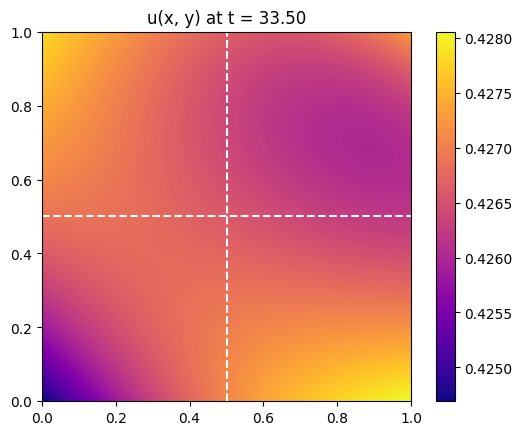

RHS max: 6.1969e-03, min: -4.0375e-03, mean: 1.6481e-04
iter: 68 ###############################
    Epoch [80/800], Loss: 0.00001113
    Epoch [160/800], Loss: 0.00001039
    Epoch [240/800], Loss: 0.00001039
    Epoch [320/800], Loss: 0.00001039
    Epoch [400/800], Loss: 0.00001039
    Epoch [480/800], Loss: 0.00001039
    Epoch [560/800], Loss: 0.00001039
    Epoch [640/800], Loss: 0.00001039
    Epoch [720/800], Loss: 0.00001039
    Epoch [800/800], Loss: 0.00001039
    Energy after iteration 68: 0.182104


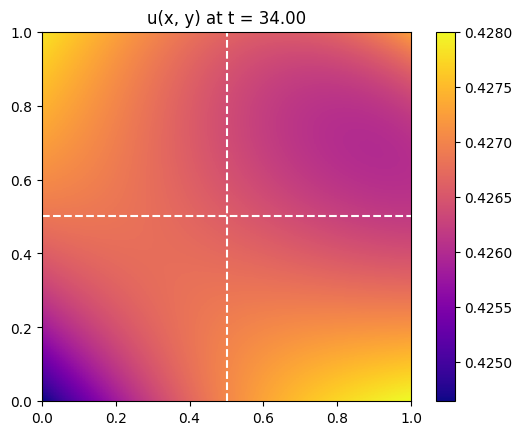

RHS max: 6.3428e-03, min: -3.8788e-03, mean: 2.1039e-04
iter: 69 ###############################
    Epoch [80/800], Loss: -0.00000963
    Epoch [160/800], Loss: -0.00001040
    Epoch [240/800], Loss: -0.00001040
    Epoch [320/800], Loss: -0.00001040
    Epoch [400/800], Loss: -0.00001040
    Epoch [480/800], Loss: -0.00001040
    Epoch [560/800], Loss: -0.00001040
    Epoch [640/800], Loss: -0.00001040
    Epoch [720/800], Loss: -0.00001040
    Epoch [800/800], Loss: -0.00001040
    Energy after iteration 69: 0.182090


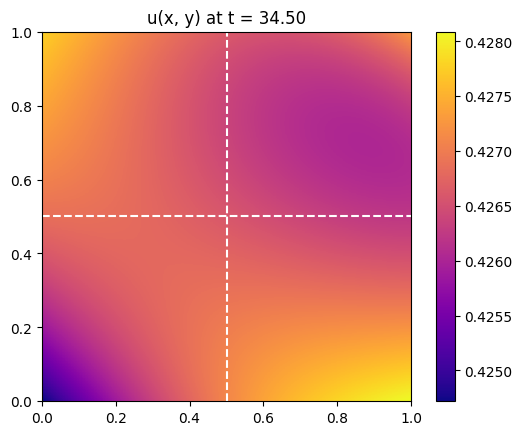

RHS max: 6.1111e-03, min: -4.1364e-03, mean: 1.4708e-04


In [30]:
tot_losses = [] 
u0_tensor = u_n.to(device)     

for n in range(int(N)):
    print(f"iter: {n} ###############################")

    if n == 0:
        apply_ic_loss = u0_tensor
        points = xy_t.clone().detach()
        # model, losses = train(deepRM, points, sigma_norm, rhs_norm, dt, lr, steps, device,
        #               ic_target=u0_tensor, full_grid=xy_t, u_n=torch.tensor(u_np.flatten(), dtype=torch.float32).to(device))
        # plt.figure(figsize=(6, 5))
        # plt.imshow(u_n.detach().cpu().numpy().reshape(n_x, n_y), origin='lower', extent=[0,1,0,1], cmap='plasma')
        # plt.colorbar()
        # plt.title("Model Output After Step 0")
        # plt.show()
    else:
        apply_ic_loss = None
        points = sample_from_pools(full_pts, disease_pts, ic_pts, colloc_p, br_ic=0.2, br_disease=0.5)
    model, losses = train(deepRM, points, sigma_norm, rhs_norm, dt, lr, steps, device,
                      ic_target=apply_ic_loss, full_grid=xy_t, u_n=torch.tensor(u_np.flatten(), dtype=torch.float32).to(device))

    tot_losses.extend(losses)

    u = model(points)
    grad_u = grad(model, points)
    grad_norm_sq = torch.sum(grad_u**2, dim=-1)
    diff = 0.5 * sigma_norm(points) * grad_norm_sq
    react = (0.5 / dt) * u**2
    src = rhs_norm(points) * u
    energy = (diff + react - src).mean()
    print(f"    Energy after iteration {n}: {energy.item():.6f}")

    with torch.no_grad():
           u_next = model(xy_t).squeeze().detach().cpu().numpy().reshape(n_x, n_y)

    u_n_prev = u_n.detach().cpu().numpy().reshape(n_x, n_y)
    
    fig, ax = plt.subplots()
    im = ax.imshow(u_next, origin='lower', extent=[0,1,0,1], cmap='plasma')
    plt.colorbar(im)
    ax.set_title(f"u(x, y) at t = {n * dt:.2f}")
    ax.axvline(x=0.5, color='white', linestyle='--')
    ax.axhline(y=0.5, color='white', linestyle='--')
    plt.show()
    

    u_n = torch.tensor(u_next.flatten(), dtype=torch.float32).to(device)
    u_np = u_next
    # u_n = u_pred.clone()
    # u_np = u_n.detach().cpu().numpy().reshape(n_x, n_y)
    rhs_v = rhs(u_np, a, fr, ft, fd, dt).flatten()
    rhs_t = torch.tensor(rhs_v, dtype=torch.float32).to(device)
    print(f"RHS max: {rhs_t.max():.4e}, min: {rhs_t.min():.4e}, mean: {rhs_t.mean():.4e}")

    graphs = stats(model, xy_t, u_n, sigma_norm, dt, a, fr, ft, fd)
    if n % 10 == 0:
        plt.figure(figsize=(6, 5))
        plt.contourf(graphs['residual'].reshape(n_x, n_y), levels=100, cmap='coolwarm')
        plt.colorbar()
        plt.title(f"PDE Residual at Iteration {n}")
        plt.show()
        
        plt.figure(figsize=(6, 5))
        plt.imshow(u_np, origin='lower', extent=[0,1,0,1], cmap='plasma')
        plt.colorbar(label='u(x, y)')
        plt.title(f"u(x, y) at T = {n*dt:.2f}")
        plt.show()

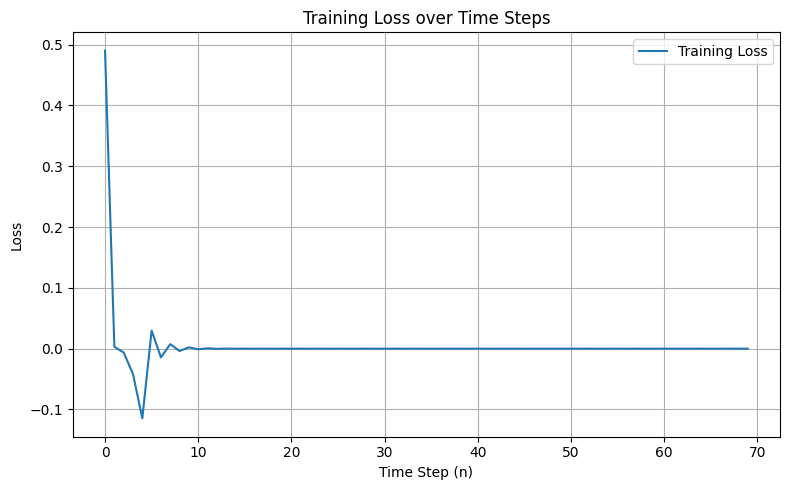

In [31]:
steps = 800  
N = len(tot_losses) // steps 

losses_per_n = [tot_losses[i * steps + (steps - 1)] for i in range(N)]
plt.figure(figsize=(8, 5))
plt.plot(losses_per_n, label='Training Loss')
plt.xlabel("Time Step (n)")
plt.ylabel("Loss")
plt.title("Training Loss over Time Steps")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

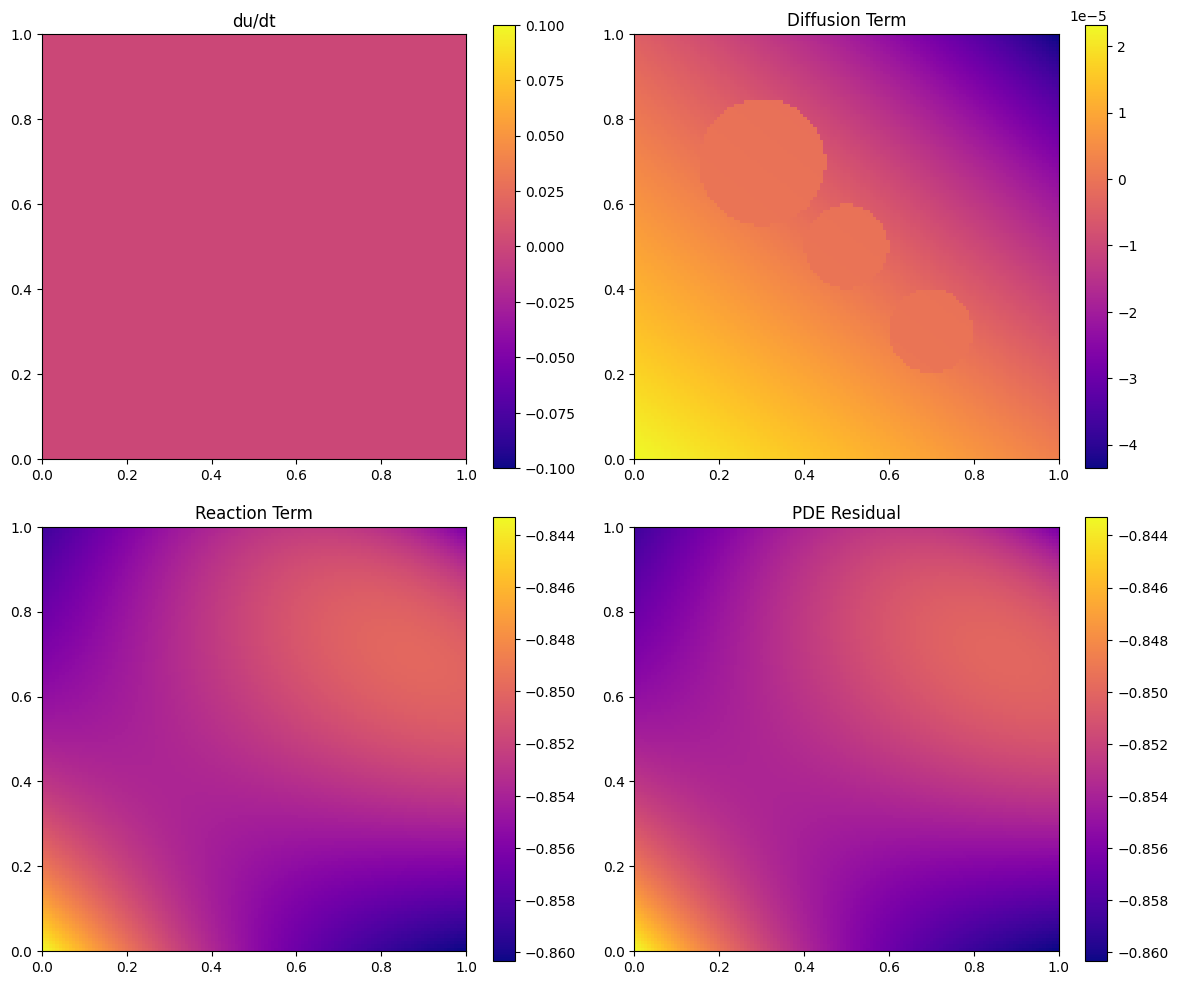

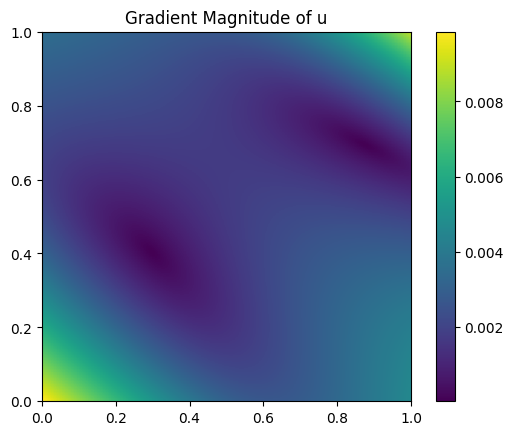

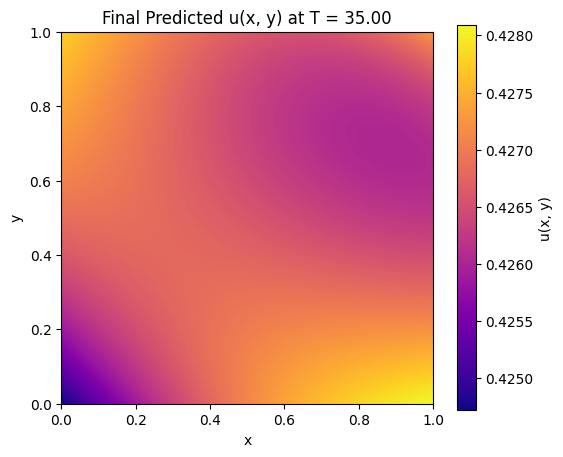

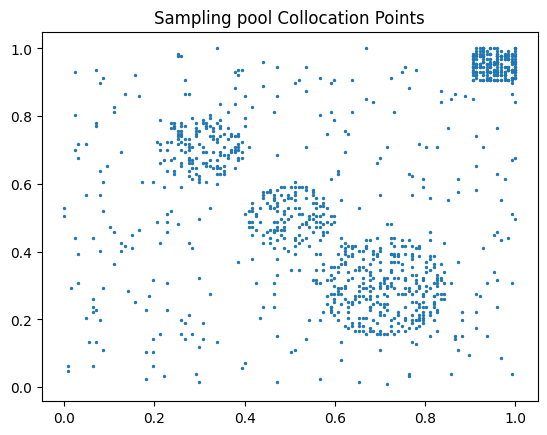

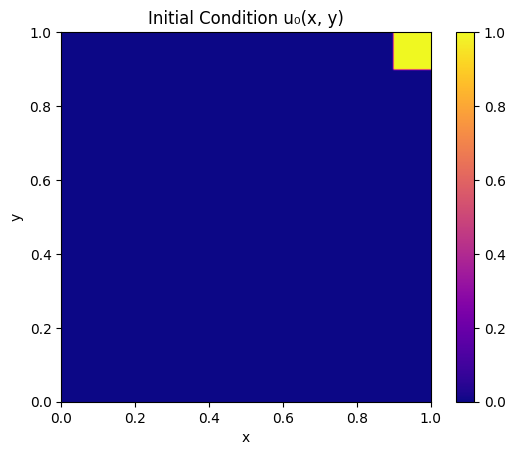

In [38]:
du_dt_map = graphs['du_dt'].reshape(n_x, n_y)
diff_map = graphs['diffusion'].reshape(n_x, n_y)
react_map = graphs['reaction'].reshape(n_x, n_y)
resid_map = graphs['residual'].reshape(n_x, n_y)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
titles = ['du/dt', 'Diffusion Term', 'Reaction Term', 'PDE Residual']
maps = [du_dt_map, diff_map, react_map, resid_map]

for ax, m, title in zip(axes.flat, maps, titles):
    im = ax.imshow(m, extent=[0, 1, 0, 1], origin='lower', cmap='plasma')
    ax.set_title(title)
    fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()


grad_mag = np.linalg.norm(graphs['grad_u'], axis=1).reshape(n_x, n_y)
plt.imshow(grad_mag, extent=[0,1,0,1], origin='lower')
plt.colorbar()
plt.title("Gradient Magnitude of u")
plt.show()

u_final = u_n.detach().cpu().numpy().reshape(n_x, n_y)

plt.figure(figsize=(6, 5))
plt.imshow(u_final, origin='lower', extent=[0,1,0,1], cmap='plasma')
plt.colorbar(label='u(x, y)')
plt.title('Final Predicted u(x, y) at T = {:.2f}'.format(N * dt))
plt.xlabel('x')
plt.ylabel('y')
plt.grid(False)
plt.show()

pts_np = points.detach().cpu().numpy()
plt.scatter(pts_np[:,0], pts_np[:,1], s=2)
plt.title("Sampling pool Collocation Points")
plt.show()

u0 = ic(n_x, n_y)
plt.imshow(u0, origin='lower', extent=[0,1,0,1], cmap='plasma')
plt.colorbar()
plt.title("Initial Condition u₀(x, y)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

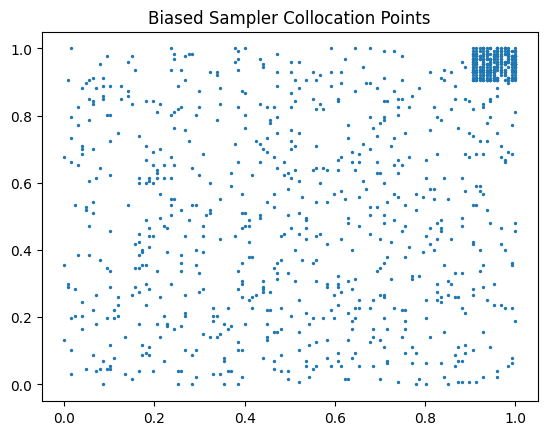

In [37]:
def sample_random_points(n_x=128, n_y=128, num_samples=1024, device='cpu'):
    # Create the full 128 x 128 grid in [0, 1] x [0, 1]
    x = np.linspace(0, 1, n_x)
    y = np.linspace(0, 1, n_y)
    X, Y = np.meshgrid(x, y, indexing='ij')

    # Flatten the grid and stack into (N, 2) coordinate pairs
    all_points = np.stack([X.flatten(), Y.flatten()], axis=-1)  # shape: (16384, 2)

    # Randomly select indices
    indices = np.random.choice(all_points.shape[0], size=num_samples, replace=False)
    sampled_points = all_points[indices]

    # Convert to torch tensor
    sampled_tensor = torch.tensor(sampled_points, dtype=torch.float32).to(device)

    return sampled_tensor


import numpy as np
import torch

def sample_biased_points(n_x=128, n_y=128, num_samples=1024, bias_fraction=0.3, device='cpu'):

    x = np.linspace(0, 1, n_x)
    y = np.linspace(0, 1, n_y)
    X, Y = np.meshgrid(x, y, indexing='ij')
    all_points = np.stack([X.flatten(), Y.flatten()], axis=-1)  # (n_x * n_y, 2)

    # Identify points in the IC region (x >= 0.9 and y >= 0.9)
    ic_mask = (all_points[:, 0] >= 0.9) & (all_points[:, 1] >= 0.9)
    ic_points = all_points[ic_mask]
    rest_points = all_points[~ic_mask]

    # Number of points to sample from each region
    n_ic = int(num_samples * bias_fraction)
    n_rest = num_samples - n_ic

    # Sample from both regions
    sampled_ic = ic_points[np.random.choice(ic_points.shape[0], size=n_ic, replace=True)]
    sampled_rest = rest_points[np.random.choice(rest_points.shape[0], size=n_rest, replace=False)]

    # Combine and shuffle
    sampled_points = np.vstack([sampled_ic, sampled_rest])
    np.random.shuffle(sampled_points)

    return torch.tensor(sampled_points, dtype=torch.float32).to(device)

p = sample_biased_points(n_x=128, n_y=128, num_samples=1024, device='cpu')
p_np = p.detach().cpu().numpy()
plt.scatter(p_np[:,0], p_np[:,1], s=2)
plt.title("Biased Sampler Collocation Points")
plt.show()